In [1]:
import glob
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage

import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial

import torchio as tio
from tqdm.auto import tqdm

## Data paths and cv-split

In [2]:
fold = -1
df = pd.read_csv('../input/train_labels_folds-v1.csv')
df_train = df[df.fold != fold]
df_val = df[df.fold == fold]
if len(df_val) == 0:
    df_val = df[df.fold == 0]

df_train.head()

BraTS21ID  MGMT_value  fold
0          0           1     2
1          2           1     2
2          3           0     1
3          5           1     2
4          6           1     0

In [3]:
npy_dir = '../input/registered_cases_v3_320x320x160/train/'
sample_fns_train = [os.path.join(npy_dir, str(_id).zfill(5) + '.npy') for _id in df_train.BraTS21ID.values]
lbls_train = list(df_train.MGMT_value.values)

sample_fns_val = [os.path.join(npy_dir, str(_id).zfill(5) + '.npy') for _id in df_val.BraTS21ID.values]
lbls_val = list(df_val.MGMT_value.values)

## [TorchIO](https://torchio.readthedocs.io/index.html)

In [4]:
def load_tio_image(fn):
    """
    ScalarImage(shape: (c, w, h, d))
    dtype: torch.DoubleTensor
    """
    arr = np.load(fn).swapaxes(0,3)
    return tio.ScalarImage(tensor=arr)

def arr_2_tio_image(arr):
    """
    ScalarImage(shape: (c, w, h, d))
    dtype: torch.DoubleTensor
    """
    arr = arr.swapaxes(0,3)
    return tio.ScalarImage(tensor=arr)

load_tio_image(sample_fns_train[0])

ScalarImage(shape: (3, 320, 320, 160); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 187.5 MiB)

In [5]:
def load_tio_seg_image(fn):
    """
    LabelMap(shape: (c, w, h, d))
    dtype: torch.FloatTensor
    
    Intensity transforms are not applied to these images.
    Nearest neighbor interpolation is always used to resample label maps.
    """
    if fn is None:
        return None
    if not os.path.exists(fn):
        return None
    arr = (np.expand_dims(np.load(fn),3).swapaxes(0,3) > 0).astype(np.float32)
    return tio.LabelMap(tensor=arr)

def arr_2_tio_seg_image(arr):
    """
    LabelMap(shape: (c, w, h, d))
    dtype: torch.FloatTensor
    
    Intensity transforms are not applied to these images.
    Nearest neighbor interpolation is always used to resample label maps.
    """
    if arr is None:
        return None
    arr = (np.expand_dims(arr,3).swapaxes(0,3) > 0).astype(np.float32)
    return tio.LabelMap(tensor=arr)

load_tio_seg_image(sample_fns_train[0].replace('.npy', '_seg.npy'))

LabelMap(shape: (1, 320, 320, 160); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 62.5 MiB)

In [6]:
def load_tio_subject(image_fn:str, label:int, seg_fn=None):
    return tio.Subject(
        rgb_image=load_tio_image(image_fn),
        segmentation=load_tio_seg_image(seg_fn),
        label=int(label),
        name=os.path.basename(image_fn).split('.')[0])

subject = load_tio_subject(
    sample_fns_train[0],
    label=0,
    seg_fn=sample_fns_train[0].replace('.npy', '_seg.npy')
)
subject

Subject(Keys: ('rgb_image', 'segmentation', 'label', 'name'); images: 2)

## 3D MRI augmentations

In [7]:
class RandomChoice(object):
    """
    choose a random tranform from list an apply
    transforms: tranforms to apply
    p: probability
    """

    def __init__(self, transforms=[],
                 p=0.5):
        self.transforms = transforms
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        t = random.choice(self.transforms)
        return t(sample)
    
class ComposeTransforms(object):
    """
    Composes several transforms together.
    """

    def __init__(self, transforms=[],
                 p=0.9):
        self.transforms = transforms
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        for t in self.transforms:
            sample = t(sample)
        return sample
    
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.filters import gaussian_filter

def stack_seg_2_image(sample):
    image = sample['image']
    seg = sample['segmentation']
    channels = [chan for chan in image]
    channels.append(seg)
    return np.stack(channels, axis=3)

def elastic_transform_3d(sample, alpha=1, sigma=20, c_val=0.0, method="linear"):
    """
    :param sample: dict of image and seg
    :param alpha: scaling factor of gaussian filter
    :param sigma: standard deviation of random gaussian filter
    :param c_val: fill value
    :param method: interpolation method. supported methods : ("linear", "nearest")
    :return: deformed image and/or label
    """
    img_numpy = sample['image'].copy()
    label = sample['segmentation'] if 'segmentation' in sample else None
    shape = img_numpy.shape
    
    # Define 3D coordinate system
    coords = np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2])

    # Interpolated images
    chan_intrps = [RegularGridInterpolator(coords, img_numpy[:,:,:,chan],
                                        method=method,
                                        bounds_error=False,
                                        fill_value=c_val) for chan in range(shape[3])]

    #Get random elastic deformations
    dx = gaussian_filter((np.random.rand(shape[0],shape[1],shape[2]) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha
    dy = gaussian_filter((np.random.rand(shape[0],shape[1],shape[2]) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha
    dz = gaussian_filter((np.random.rand(shape[0],shape[1],shape[2]) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha

    # Define sample points
    x, y, z = np.mgrid[0:shape[0], 0:shape[1], 0:shape[2]]

    indices = np.reshape(x + dx, (-1, 1)), \
              np.reshape(y + dy, (-1, 1)), \
              np.reshape(z + dz, (-1, 1))

    # Interpolate 3D image image
    img_numpy = np.stack([chan_intrp(indices).reshape((shape[0],shape[1],shape[2])) 
                          for chan_intrp in chan_intrps], axis=3).astype(np.float32)

    # Interpolate labels
    if label is not None:
        lab_intrp = RegularGridInterpolator(coords, label,
                                            method="nearest",
                                            bounds_error=False,
                                            fill_value=0)

        label = lab_intrp(indices).reshape(shape[0],shape[1],shape[2]).astype(label.dtype)
        sample['segmentation'] = label
    
    sample['image'] = img_numpy
    return sample


class ElasticTransform(object):
    def __init__(self, p=0.5, alpha=1, sigma=20, c_val=0.0, method="linear"):
        self.p = p
        self.alpha = alpha
        self.sigma = sigma
        self.c_val = c_val
        self.method = method

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return elastic_transform_3d(sample, self.alpha, self.sigma, self.c_val, self.method)
    
def random_noise(sample, mean=0, std=0.001, eps=1e-6):
    im = sample['image'].copy()
    noise = np.random.normal(mean, std, im.shape)
    sample['image'] = np.where(im > eps, im + noise, im)
    return sample


class GaussianNoise(object):
    def __init__(self, p=0.5, mean=0, std=0.001):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        
        return random_noise(sample, self.mean, self.std)
    
def random_crop_to_size(sample, crop_sz):
    
    im = sample['image'].copy()
    shape = im.shape
    
    if 'segmentation' in sample:
        seg = sample['segmentation'].copy()
    else:
        seg = None
        
    # choose randomly but check that at least one tumor pixel is included
    width, height, depth = crop_sz
    
    sum_tumor = 0
    n_round = 0
    d,x,y = 0,0,0
    while sum_tumor == 0 and n_round < 1000:
        n_round += 1
        d = np.random.randint(0, shape[0] - depth - 1)
        x = np.random.randint(0, shape[1] - width - 1)
        y = np.random.randint(0, shape[2] - height - 1)
        if seg is not None:
            check = seg[d:d+depth, x:x+width, y:y+height]
            sum_tumor = np.sum(check)
        else:
            sum_tumor = 1
    
    assert n_round < 1000, f'no segmentation found in {sample["BraTSID"]}'
    
    im = im[d:d+depth, x:x+width, y:y+height,:]
    sample['image'] = im
    
    if seg is not None:
        seg = check
        sample['segmentation'] = seg
    
    return sample

class RandomCropToSize(object):
    
    def __init__(self, crop_sz=(200,200,95)):
        self.crop_sz = crop_sz

    def __call__(self, sample):
        return random_crop_to_size(sample, self.crop_sz)
    
def random_flip_lr(sample):
    im = sample['image'].copy()
    seg = sample['segmentation'].copy()
    im = im[:,:,::-1,:]
    seg = seg[:,:,::-1]
    
    sample['image'] = im
    sample['segmentation'] = seg
    
    return sample

class RandomFlipLR(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return random_flip_lr(sample)

def random_channel_drop(sample):
    im = sample['image'].copy()
    c = im.shape[3]
    drop_ch = random.randint(0, c-1)
    im[:,:,:,drop_ch] = 0. if random.random() > 0.5 else 1.0
    sample['image'] = im
    return sample
    
class RandomChannelDrop(object):
    def __init__(self, p=0.05):
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return random_channel_drop(sample)

def random_rotate3D(sample, min_angle, max_angle):
    """
    Returns a random rotated image and seg map in sample dict
    :param sample: ds sample dict
    :param min_angle: in degrees
    :param max_angle: in degrees
    :return: sample
    """
    im = sample['image'].copy()
    seg = sample['segmentation'].copy()
    assert min_angle < max_angle, "min should be less than max val"
    assert min_angle > -360 or max_angle < 360
    all_axes = [(1, 0), (1, 2), (0, 2)]
    
    angle = np.random.randint(low=min_angle, high=max_angle + 1)
    axes_random_id = np.random.randint(low=0, high=len(all_axes))
    axes = all_axes[axes_random_id]
    
    im = ndimage.interpolation.rotate(im , angle, axes=axes, reshape=False)
    
    seg = ndimage.rotate(seg.astype(np.float32), angle, axes=axes, reshape=False)
    
    # seg back to binary float values
    seg = np.where(seg < 0.5, 0, 1.)
    
    sample['image'] = im
    sample['segmentation'] = seg
    
    return sample


class RandomRotation(object):
    def __init__(self, min_angle=-10, max_angle=10, p=0.5):
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return random_rotate3D(sample, self.min_angle, self.max_angle)
    
class DownSampleSegmentation(object):
    def __init__(self, ds=4):
        self.ds = ds
        
    def __call__(self, sample):
        if 'segmentation' in sample:
            seg = sample['segmentation']
            seg = seg[::self.ds, ::self.ds, ::self.ds]
            sample['segmentation'] = seg
        return sample

## Dataset

In [8]:
class BraTS2021(Dataset):
    """
    Dataset for BraTS2021 challenge - Includes tasks 1 and 2
    """

    def __init__(self, mode, 
                 npy_fns_list,
                 label_list=[],
                 augmentations=None,
                 tio_augmentations=None,
                 volume_normalize=True,
                 segmentation_classes=False,
                 max_out_size=(320,320,160),
                 label_smoothing=0.4
                ):
        """
        :param mode: 'train','val','test'
        :param npy_fns_list: list of numpy array paths
        :param label_list: list of binary label integers
        :param augmentations: 3D augmentations
        :param tio_augmentations: TorchIO 3D augmentations
        :param volume_normalize: z-score normalize each channel in sample
        :param segmentation_classes: use two tumor segmentation classes for No-MGMT and MGMT 
        :param max_out_size: max out dimensions (x,y,z), if data is larger, it is cropped to this
        :param label_smoothing: applied to label values only on train mode
        """
        self.mode = mode
        self.augmentations = augmentations
        self.tio_augmentations = tio_augmentations
        self.volume_normalize = volume_normalize
        self.segmentation_classes = segmentation_classes
        self.max_out_size = max_out_size
        self.label_smoothing = label_smoothing
        
        self.seg_fn_list = []
        self.fn_list = npy_fns_list
        self.label_list = label_list
        
        if self.mode != "test":
            fn_list_with_seg = []
            label_list_with_seg = []
            for fn, lbl in zip(npy_fns_list, label_list):
                fn_seg = str(fn).replace('.npy', '_seg.npy')
                if os.path.exists(fn_seg) and os.path.exists(fn):
                    fn_list_with_seg.append(fn)
                    self.seg_fn_list.append(fn_seg)
                    label_list_with_seg.append(int(lbl))
            
            # update fn list and exclude ones that don't have seg map
            self.fn_list = fn_list_with_seg
            self.label_list = label_list_with_seg
            assert len(self.fn_list) == len(self.seg_fn_list) == len(self.label_list)
        
        ########################
        #### Sanity checks #####
        
        assert len(self.fn_list) > 0
        
        # Check one sample
        one_sample = np.load(self.fn_list[0])
        assert len(one_sample.shape) == 4
        d,x,y,c = one_sample.shape
        self.full_vol_dim = (x,y,d)
        self.channels = c
        
        # Check one seg map
        if len(self.seg_fn_list) > 0:
            one_seg_sample = np.load(self.seg_fn_list[0])
            assert len(one_seg_sample.shape) == 3
            seg_d,seg_x,seg_y = one_seg_sample.shape
            assert seg_d == d
            assert seg_x == x
            assert seg_y == y
            
        #### Sanity checks #####
        ########################
        
        # shuffle samples
        if self.mode == "train":
            all_lists = list(zip(self.fn_list, self.seg_fn_list, self.label_list))
            random.shuffle(all_lists)
            self.fn_list, self.seg_fn_list, self.label_list = zip(*all_lists)
        
    def __len__(self):
        return len(self.fn_list)

    def __getitem__(self, index):
        sample = np.load(self.fn_list[index]).astype(np.float32)
        # fillna
        sample = np.nan_to_num(sample, nan=0)
        out_dict = {
            'BraTSID' : int(os.path.basename(self.fn_list[index]).split('.')[0]),
            'image' : sample
        }
        
        # Calculate stats from full image
        sample_mean = np.mean(sample, axis=tuple([0,1,2]))
        sample_std = np.std(sample, axis=tuple([0,1,2])) + 1e-6
        
        # Load labels
        if self.mode != "test":
            seg = np.load(self.seg_fn_list[index])
            # set seg to binary values
            seg = (seg > 0).astype(np.float32)
            lbl = self.label_list[index]
            if self.mode == 'train':
                if lbl > 0.5:
                    lbl = lbl - self.label_smoothing
                else:
                    lbl = self.label_smoothing
            out_dict['segmentation'] = seg 
            out_dict['label'] = lbl
        
        # augment
        if self.augmentations:
            out_dict = self.augmentations(out_dict)
        
        # TorchIO augs
        if self.tio_augmentations:
            subject = tio.Subject(
                rgb_image = arr_2_tio_image(out_dict['image']),
                segmentation = arr_2_tio_seg_image(out_dict['segmentation'])
            )
            subject = self.tio_augmentations(subject)
            out_dict['image'] = subject.rgb_image.numpy().swapaxes(0,3)
            out_dict['segmentation'] = subject.segmentation.numpy().swapaxes(0,3)[:,:,:,0]
        
        # Process segmentation map
        if 'segmentation' in out_dict:
            if self.segmentation_classes:
                # split segmentation to two
                empty_seg = np.zeros_like(out_dict['segmentation'])
                if lbl == 0:
                    out_dict['segmentation'] = np.stack([out_dict['segmentation'], empty_seg], axis=3)
                else:
                    out_dict['segmentation'] = np.stack([empty_seg, out_dict['segmentation']], axis=3)
            else:
                # Add channel dimension to segmentation
                out_dict['segmentation'] = np.expand_dims(out_dict['segmentation'], axis=3)
            
            # swap channel axis in image with depth axis - torch wants channel first
            out_dict['segmentation'] = np.swapaxes(out_dict['segmentation'], 0, 3)
        
        # z-score norm each channel - done after augmentations
        if self.volume_normalize:
            sample = out_dict['image']
            sample = (sample - sample_mean) / sample_std
            out_dict['image'] = sample
            out_dict['mean'] = sample_mean
            out_dict['std'] = sample_std
        else:
            out_dict['mean'] = np.array([0 for _ in range(sample.shape[3])])
            out_dict['std'] = np.array([1. for _ in range(sample.shape[3])])
        
        # swap channel axis in image with depth axis - torch wants channel first
        out_dict['image'] = np.swapaxes(out_dict['image'], 0, 3)
        
        # check that size doesn't exceed max size
        im_shape = list(out_dict['image'].shape[1:])
        for i, max_sz in enumerate(self.max_out_size):
            im_shape[i] = min(im_shape[i], max_sz)
        out_dict['image'] = out_dict['image'][:,:im_shape[0],:im_shape[1],:im_shape[2]]
        if 'segmentation' in out_dict:
            out_dict['segmentation'] = out_dict['segmentation'][:,:im_shape[0],:im_shape[1],:im_shape[2]]
        
        # convert values to torch and arrays
        for key, val in out_dict.items():
            if key == 'label':
                out_dict[key] = np.array(val)
            elif key == 'BraTSID':
                out_dict[key] = np.array(val)
            else:
                out_dict[key] = torch.FloatTensor(val.copy())
            
        return out_dict

In [9]:
#crop_sz = (192,192,96)
crop_sz = (128,128,64)
max_out_size=crop_sz

tio_augmentations = tio.Compose([
    tio.RandomAffine(p=0.5),
    tio.RandomBiasField(p=0.3),
    tio.RandomGhosting(p=0.05),
    tio.RandomElasticDeformation(p=0.2),
    tio.RandomSpike(p=0.05),
    tio.RandomNoise(p=0.1),
    tio.RandomAnisotropy(p=0.05),
    tio.RandomFlip(p=0.5),
    #tio.RandomSwap(p=0.05),
    tio.RandomBlur(p=0.1),
    tio.RandomGamma(p=0.15),
])

augmentations = ComposeTransforms([
    RandomCropToSize(crop_sz=crop_sz),
], p=1.0)

train_ds = BraTS2021(
    mode='train', 
    npy_fns_list=sample_fns_train, 
    label_list=lbls_train,
    augmentations=augmentations,
    tio_augmentations=tio_augmentations,
    volume_normalize=True,
    max_out_size=max_out_size
)

val_augmentations = ComposeTransforms([
    RandomCropToSize(crop_sz=crop_sz),
], p=1.0)

val_ds = BraTS2021(
    mode='val', 
    npy_fns_list=sample_fns_val, 
    label_list=lbls_val,
    augmentations=val_augmentations,
    volume_normalize=True,
    max_out_size=max_out_size
)

In [10]:
%%time
sample = train_ds.__getitem__(1)

CPU times: user 996 ms, sys: 384 ms, total: 1.38 s
Wall time: 1.68 s


In [11]:
img = sample['image']
img.shape, img.dtype

(torch.Size([3, 128, 128, 64]), torch.float32)

In [12]:
sample['segmentation'].dtype

torch.float32

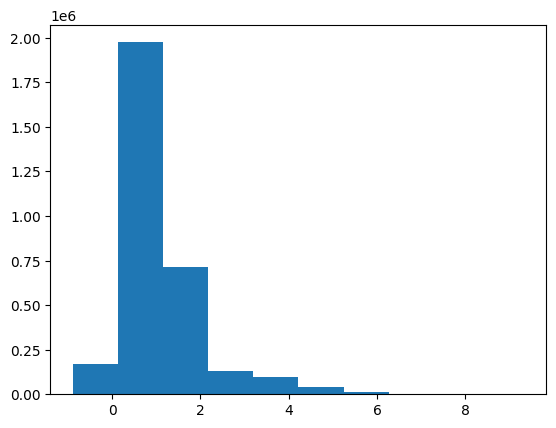

In [13]:
plt.hist(sample['image'].numpy().flatten())
plt.show()

In [14]:
sample['segmentation']

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [15]:
val_ds.__getitem__(1)['image'].shape, val_ds.__getitem__(1)['image'].dtype

(torch.Size([3, 128, 128, 64]), torch.float32)

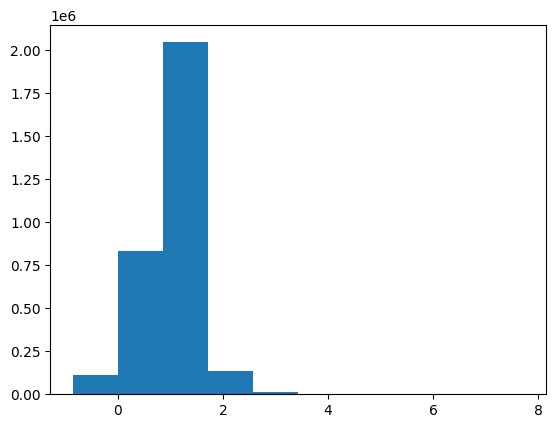

In [16]:
plt.hist(val_ds.__getitem__(1)['image'].numpy().flatten())
plt.show()

In [17]:
val_ds.__getitem__(1)['segmentation'].dtype 

torch.float32

## Visualization

In [18]:
def make_bg_transparent(im, bg_th=0.0, set_to_color=None):
    # create transparency alpha channel
    # convert image to RGBA
    if len(im.shape) == 3:
        alpha_c = (np.sum(im[:,:,:],axis=2) > bg_th).astype(im.dtype)
        c1,c2,c3 = cv2.split(im)
    else:
        alpha_c = (im[:,:] > bg_th).astype(im.dtype)
        c1,c2,c3 = im.copy(), im.copy(), im.copy()
    if set_to_color is not None:
        zeros = np.zeros_like(c1)
        if set_to_color == 'green':
            merged = np.stack([zeros,c2,zeros,alpha_c], axis=-1)
        elif set_to_color == 'red':
            merged = np.stack([c1,zeros,zeros,alpha_c], axis=-1)
        elif set_to_color == 'royalblue':
            merged = np.stack([c1,zeros,zeros,alpha_c], axis=-1)
        elif set_to_color == 'violet':
            merged = np.stack([c1,zeros,c3,alpha_c], axis=-1)
        elif set_to_color == 'yellow':
            merged = np.stack([c1,c2,zeros,alpha_c], axis=-1)
    else:
        merged = np.stack([c1,c2,c3,alpha_c], axis=-1)
    return merged

def to_3d_points(im, th=1e-6, downsample=5):
    xs,ys,ds = [],[],[]
    if len(im.shape) == 4:
        im3d = np.sum(im,axis=3)
    else:
        im3d = im
    depth,width,height = im3d.shape
    step_vol = downsample**3
    for x in range(0, width - downsample, downsample):
        for y in range(0, height - downsample, downsample):
            for d in range(0, depth - downsample, downsample):
                if (np.sum(im3d[d:d+downsample, x:x+downsample, y:y+downsample]) / step_vol) > th:
                    xs.append(x + (downsample//2))
                    ys.append(y + (downsample//2))
                    ds.append(d + (downsample//2))
    return np.array(xs), np.array(ys), np.array(ds)

def adjust_saturation(img, sat_scale=0.3):
    hsv_im = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    (h, s, v) = cv2.split(hsv_im)
    s = s*sat_scale
    s = np.clip(s,0,255)
    hsv_im = np.stack([h,s,v],axis=2).astype(np.uint8)
    return cv2.cvtColor(hsv_im, cv2.COLOR_HSV2RGB) / 255.

def show_mri_sample(sample, pred_mask=None, pred_lbl=None, seg_downsample=None, save_fn=None):
    """ Plot sample in three projections """
    plt.close('all')
    
    alpha=0.5
    image_alpha=1.0
    
    ims = sample['image'].numpy()
    means = sample['mean'].numpy()
    stds = sample['std'].numpy()
    segs = sample['segmentation'].numpy() if 'segmentation' in sample else None
    
    # add batch dims if missing
    if ims.ndim == 4:
        ims = np.expand_dims(ims, 0)
        means = np.expand_dims(means, 0)
        stds = np.expand_dims(stds, 0)
        if segs is not None:
            segs = np.expand_dims(segs, 0)
    
    n_images = len(ims)
    n_root = int(np.ceil(np.sqrt(n_images)))
    n_cols = n_root * 2
    n_rows = n_root * 2
    # special case fix to get with correct with small bs
    if n_images == 2:
        n_rows = 2
    
    fig_scale = 2
    f = plt.figure(figsize=(fig_scale*n_cols,fig_scale*n_rows))
    
    # Read additional meta from batch
    brats_ids = [sample['BraTSID']] if n_images == 1 else sample['BraTSID']
    labels = None
    if 'label' in sample:
        labels = [sample['label']] if n_images == 1 else sample['label']
    
    def _subplot_index(index, row_off, col_off):
        startrow = (index * 2)//n_cols
        startcol = (index * 2)%n_cols
        return (2*startrow+row_off)*n_cols + (startcol + col_off) + 1
    
    for index in range(n_images):
        im = ims[index]
        seg = segs[index]
        seg = np.swapaxes(seg, 0,3)
        # upsample seg back to original size if it has been downsampled
        if seg_downsample is not None:
            seg = seg.repeat(seg_downsample, axis=0).repeat(seg_downsample, axis=1).repeat(seg_downsample, axis=2)
        
        # Normalize images for visualization
        im = np.swapaxes(im, 0,3) # swap depth and chan axes
        im = (im * stds[index]) + means[index]
    
        title = f'BraTSID: {brats_ids[index]}'
        if labels is not None:
            title += f', GT-MGMT:{labels[index]}'
        if pred_lbl is not None:
            title += f'\nPred-MGMT:{float(pred_lbl[index][0]):.3f}'
    
        d,x,y,c = im.shape
        
        coronal_ax = f.add_subplot(n_rows,n_cols, _subplot_index(index,0,0))
        coronal_ax.set_title(title + ' - coronal', fontsize=8)
        coronal_ax.imshow(make_bg_transparent(adjust_saturation(im[::-1,x//2,:,:])), alpha=image_alpha)
    
        sagittal_ax = f.add_subplot(n_rows,n_cols,_subplot_index(index,0,1))
        sagittal_ax.set_title(title + ' - sagittal', fontsize=8)
        sagittal_ax.get_yaxis().set_visible(False)
        sagittal_ax.imshow(make_bg_transparent(adjust_saturation(im[::-1,:,y//2,:])), alpha=image_alpha)
    
        axial_ax = f.add_subplot(n_rows,n_cols,_subplot_index(index,1,0))
        axial_ax.set_title(title + ' - axial', fontsize=8)
        axial_ax.imshow(make_bg_transparent(adjust_saturation(im[d//2,:,:,:])), alpha=image_alpha)
    
        proj_ax = f.add_subplot(n_rows, n_cols, _subplot_index(index,1,1), projection='3d')
        proj_ax.scatter(*to_3d_points(im), color='gray', alpha=0.015, s=5, depthshade=False)
        proj_ax.set_title(f'Green=GT-tumor, Red=Pred-tumor\n{title}', fontsize=6)
        proj_ax.set_xticks([])                               
        proj_ax.set_yticks([])                               
        proj_ax.set_zticks([])
    
        if seg is not None:
            for seg_chan, color in zip(range(seg.shape[3]),['green']):
                coronal_ax.imshow(make_bg_transparent(seg[::-1,x//2,:,seg_chan], set_to_color=color), alpha=alpha)
                sagittal_ax.imshow(make_bg_transparent(seg[::-1,:,y//2,seg_chan], set_to_color=color), alpha=alpha)
                axial_ax.imshow(make_bg_transparent(seg[d//2,:,:,seg_chan], set_to_color=color), alpha=alpha)
                proj_ax.scatter(*to_3d_points(seg[:,:,:,seg_chan]), color=color, s=5, alpha=0.05)
    
        if pred_mask is not None:
            pred = np.swapaxes(pred_mask[index].cpu().numpy(), 0,3)
            pred = np.clip(pred, 0, 1.)
            # upsample seg back to original size if it has been downsampled
            if seg_downsample is not None:
                pred = pred.repeat(seg_downsample, axis=0).repeat(seg_downsample, axis=1).repeat(seg_downsample, axis=2)
            for seg_chan, color in zip(range(pred.shape[3]),['red']):
                coronal_ax.imshow(make_bg_transparent(pred[::-1,x//2,:, seg_chan], set_to_color=color, bg_th=0.5), alpha=alpha)
                sagittal_ax.imshow(make_bg_transparent(pred[::-1,:,y//2, seg_chan], set_to_color=color, bg_th=0.5), alpha=alpha)
                axial_ax.imshow(make_bg_transparent(pred[d//2,:,:, seg_chan], set_to_color=color, bg_th=0.5), alpha=alpha)
                proj_ax.scatter(*to_3d_points(pred[:,:,:,seg_chan], th=0.5), color=color, s=5, alpha=0.05)
        
        # draw axial lines
        coronal_ax.plot([0,x-1],[d//2,d//2],'--',color='white', linewidth=1) # coronal horizontal
        coronal_ax.plot([x//2,x//2],[0,d-1],'--',color='white', linewidth=1) # coronal vertical
        sagittal_ax.plot([0,y-1],[d//2,d//2],'--',color='white', linewidth=1) # sagittal horizontal
        sagittal_ax.plot([y//2,y//2],[0,d-1],'--',color='white', linewidth=1) # sagittal vertical
        axial_ax.plot([0,y-1],[x//2,x//2],'--',color='white', linewidth=1) # axial horizontal
        axial_ax.plot([x//2,x//2],[0,y-1],'--',color='white', linewidth=1) # axial vertical
    
    plt.subplots_adjust(left=0.00,top=1.,right=1.,bottom=0.00, wspace=0.15, hspace=0.15)
    
    bbox = f.get_window_extent().transformed(f.dpi_scale_trans.inverted())
    width, height = bbox.width*f.dpi, bbox.height*f.dpi
    width *= 1.05
    height *= 1.05
    #if n_images == 2:
    #    n_rows = 2
    
    for row in range(0, n_rows,2):
        if n_images == 2 and row > 0:
            break
        for col in range(0, n_cols,2):
            different_color = (row//2) % 2 == (col//2) % 2
            color = (1,1,1) if different_color else (0.8,0.8,0.8)
            
            f.patches.extend([
                plt.Rectangle(
                    (width * col / n_cols, height * (n_rows - row - 2) / n_rows), 
                    width / max(1,n_cols//2), 
                    height / max(1,n_rows//2),
                    fill=True, 
                    color=color,  
                    zorder=-1, # below axes
                    alpha=0.5,
                    transform=None, 
                    figure=f)
            ])
    
    if save_fn is not None:
        plt.savefig(save_fn, transparent=False)
    else:
        plt.show()

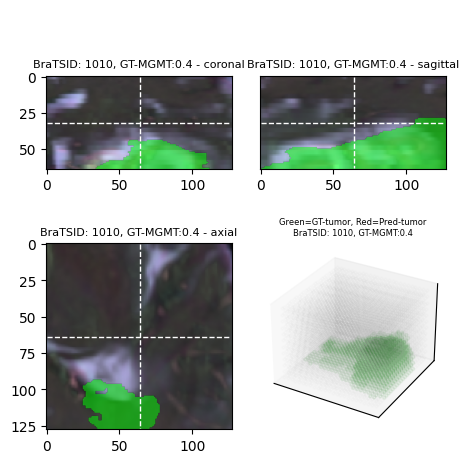

In [19]:
show_mri_sample(sample, seg_downsample=None)

In [20]:
from torch.utils.data import DataLoader

dl_args = {
    'batch_size': 2,
    'shuffle': True,
    'num_workers': 8,
}

train_generator = DataLoader(train_ds, **dl_args)
val_generator = DataLoader(val_ds, **dl_args)

In [21]:
#batch = None
#for i, batch in enumerate(val_generator):
#    print(torch.sum(torch.isnan(batch['image'])), torch.sum(torch.isnan(batch['segmentation'])))
#    if torch.sum(torch.isnan(batch['image'])).numpy() > 0:
#        break
#    #show_mri_sample(batch)

## Model

In [22]:
from abc import ABC, abstractmethod
import torch
import torch.nn as nn

class BaseModel(nn.Module, ABC):
    r"""
    BaseModel with basic functionalities for checkpointing and restoration.
    """

    def __init__(self):
        super().__init__()
        self.best_loss = 1000000

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def test(self):
        """
        To be implemented by the subclass so that
        models can perform a forward propagation
        :return:
        """
        pass

    @property
    def device(self):
        return next(self.parameters()).device

    def restore_checkpoint(self, ckpt_file, optimizer=None):
        r"""
        Restores checkpoint from a pth file and restores optimizer state.

        Args:
            ckpt_file (str): A PyTorch pth file containing model weights.
            optimizer (Optimizer): A vanilla optimizer to have its state restored from.

        Returns:
            int: Global step variable where the model was last checkpointed.
        """
        if not ckpt_file:
            raise ValueError("No checkpoint file to be restored.")

        try:
            ckpt_dict = torch.load(ckpt_file)
        except RuntimeError:
            ckpt_dict = torch.load(ckpt_file, map_location=lambda storage, loc: storage)
        # Restore model weights
        self.load_state_dict(ckpt_dict['model_state_dict'])

        # Restore optimizer status if existing. Evaluation doesn't need this
        # TODO return optimizer?????
        if optimizer:
            optimizer.load_state_dict(ckpt_dict['optimizer_state_dict'])

        # Return global step
        return ckpt_dict['epoch']

    def save_checkpoint(self,
                        directory,
                        epoch, loss,
                        optimizer=None,
                        name=None):
        r"""
        Saves checkpoint at a certain global step during training. Optimizer state
        is also saved together.

        Args:
            directory (str): Path to save checkpoint to.
            epoch (int): The training. epoch
            optimizer (Optimizer): Optimizer state to be saved concurrently.
            name (str): The name to save the checkpoint file as.

        Returns:
            None
        """
        # Create directory to save to
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Build checkpoint dict to save.
        ckpt_dict = {
            'model_state_dict':
                self.state_dict(),
            'optimizer_state_dict':
                optimizer.state_dict() if optimizer is not None else None,
            'epoch':
                epoch
        }

        # Save the file with specific name
        if name is None:
            name = "{}_{}_epoch.pth".format(
                os.path.basename(directory),  # netD or netG
                'last')

        torch.save(ckpt_dict, os.path.join(directory, name))
        if self.best_loss > loss:
            self.best_loss = loss
            name = "{}_BEST.pth".format(
                os.path.basename(directory))
            torch.save(ckpt_dict, os.path.join(directory, name))

    def count_params(self):
        r"""
        Computes the number of parameters in this model.

        Args: None

        Returns:
            int: Total number of weight parameters for this model.
            int: Total number of trainable parameters for this model.

        """
        num_total_params = sum(p.numel() for p in self.parameters())
        num_trainable_params = sum(p.numel() for p in self.parameters()
                                   if p.requires_grad)

        return num_total_params, num_trainable_params

    def inference(self, input_tensor):
        self.eval()
        with torch.no_grad():
            output = self.forward(input_tensor)
            if isinstance(output, tuple):
                output = output[0]
            return output.cpu().detach()

In [23]:
from torchsummary import summary
from collections import OrderedDict

class AdaptiveConcatPool3d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool3d(sz)
        self.mp = nn.AdaptiveMaxPool3d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class UNet3D_v2(BaseModel):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet3D_v2, self).__init__()

        features = init_features
        self.encoder1 = UNet3D_v2._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder2 = UNet3D_v2._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder3 = UNet3D_v2._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder4 = UNet3D_v2._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.bottleneck = UNet3D_v2._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose3d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet3D_v2._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose3d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet3D_v2._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose3d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet3D_v2._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose3d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet3D_v2._block(features * 2, features, name="dec1")

        
        
        self.conv = nn.Conv3d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        
        n_fn = features
        self.clf_head = nn.Sequential(
            AdaptiveConcatPool3d(sz=1),
            nn.Flatten(),
            nn.Dropout(0.40),
            nn.ReLU(inplace=True),
            nn.Linear(n_fn * 2, 1)
        )
        

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        seg = self.conv(dec1)
        clf = self.clf_head(dec1)
        
        return torch.sigmoid(seg), clf

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv3d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    #(name + "norm1", nn.BatchNorm3d(num_features=features)),
                    (name + "norm1", nn.InstanceNorm3d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv3d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    #(name + "norm2", nn.BatchNorm3d(num_features=features)),
                    (name + "norm2", nn.InstanceNorm3d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )
    
    def test(self,device='cpu'):

        input_tensor = torch.rand(1, 2, 32, 32, 32)
        ideal_out = torch.rand(1, self.n_classes, 32, 32, 32)
        out = self.forward(input_tensor)
        assert ideal_out.shape == out.shape
        summary(self.to(torch.device(device)), (2, 32, 32, 32),device='cpu')
        print("Unet3D test is complete")

In [24]:
model_unet3d_v2 = UNet3D_v2(out_channels=1)

In [25]:
empty_state = model_unet3d_v2.state_dict()

model2d = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/joni/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [26]:
trained_2d_state = model2d.state_dict()

In [27]:
for key_3d in empty_state.keys():
    if key_3d not in trained_2d_state.keys(): 
        print(f'skip {key_3d}')
        continue
    weight_3d, weight_2d = empty_state[key_3d], trained_2d_state[key_3d]
    
    # if shapes are same, regular copy
    if weight_3d.shape == weight_2d.shape:
        empty_state[key_3d] = trained_2d_state[key_3d].clone()
    # don't copy final layer
    elif key_3d != 'conv.weight' and key_3d != 'conv.bias': 
        weight = trained_2d_state[key_3d].clone()
        empty_state[key_3d] = weight.unsqueeze(2).repeat(1, 1, weight.size(2), 1, 1)

skip clf_head.4.weight
skip clf_head.4.bias


In [28]:
model_unet3d_v2.load_state_dict(empty_state)

<All keys matched successfully>

In [29]:
model = model_unet3d_v2.cuda()

## Optim

In [30]:
import torch.optim as optim

optimizer_name = "adam" #'sgd'
lr= 3e-3
weight_decay = 0.0000000001

if optimizer_name == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=weight_decay)
elif optimizer_name == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=lr)
elif optimizer_name == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

In [31]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=6500, eta_min=1e-6, verbose=False)

## Loss (3D segmentation)

In [32]:
# Code was adapted and mofified from https://github.com/wolny/pytorch-3dunet/blob/master/pytorch3dunet/unet3d/losses.py


class _AbstractDiceLoss(nn.Module):
    """
    Base class for different implementations of Dice loss.
    """

    def __init__(self, weight=None, sigmoid_normalization=True):
        super(_AbstractDiceLoss, self).__init__()
        self.register_buffer('weight', weight)
        self.classes = None
        self.skip_index_after = None
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify sigmoid_normalization=False.
        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)

    def dice(self, input, target, weight):
        # actual Dice score computation; to be implemented by the subclass
        raise NotImplementedError

    def skip_target_channels(self, target, index):
        """
        Assuming dim 1 is the classes dim , it skips all the indexes after the desired class
        """
        assert index >= 2
        return target[:, 0:index, ...]

    def forward(self, input, target):
        """
        Expand to one hot added extra for consistency reasons
        """
        target = expand_as_one_hot(target.long(), self.classes)

        assert input.dim() == target.dim() == 5, "'input' and 'target' have different number of dims"

        if self.skip_index_after is not None:
            before_size = target.size()
            target = self.skip_target_channels(target, self.skip_index_after)
            print("Target {} after skip index {}".format(before_size, target.size()))

        assert input.size() == target.size(), "'input' and 'target' must have the same shape"
        # get probabilities from logits
        #input = self.normalization(input)

        # compute per channel Dice coefficient
        per_channel_dice = self.dice(input, target, weight=self.weight)

        loss = (1. - torch.mean(per_channel_dice))
        per_channel_dice = per_channel_dice.detach().cpu().numpy()

        # average Dice score across all channels/classes
        return loss, per_channel_dice

def expand_as_one_hot(input, C, ignore_index=None):
    """
    Converts NxDxHxW label image to NxCxDxHxW, where each label gets converted to its corresponding one-hot vector
    :param input: 4D input image (NxDxHxW)
    :param C: number of channels/labels
    :param ignore_index: ignore index to be kept during the expansion
    :return: 5D output image (NxCxDxHxW)
    """
    if input.dim() == 5:
        return input
    assert input.dim() == 4

    # expand the input tensor to Nx1xDxHxW before scattering
    input = input.unsqueeze(1)
    # create result tensor shape (NxCxDxHxW)
    shape = list(input.size())
    shape[1] = C

    if ignore_index is not None:
        # create ignore_index mask for the result
        mask = input.expand(shape) == ignore_index
        # clone the lib tensor and zero out ignore_index in the input
        input = input.clone()
        input[input == ignore_index] = 0
        # scatter to get the one-hot tensor
        result = torch.zeros(shape).to(input.device).scatter_(1, input, 1)
        # bring back the ignore_index in the result
        result[mask] = ignore_index
        return result
    else:
        # scatter to get the one-hot tensor
        return torch.zeros(shape).to(input.device).scatter_(1, input, 1)
    
def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)
    
def compute_per_channel_dice(input, target, epsilon=1e-6, weight=None):
    """
    Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given  a multi channel input and target.
    Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.

    Args:
         input (torch.Tensor): NxCxSpatial input tensor
         target (torch.Tensor): NxCxSpatial target tensor
         epsilon (float): prevents division by zero
         weight (torch.Tensor): Cx1 tensor of weight per channel/class
    """

    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    input = flatten(input)
    target = flatten(target)
    target = target.float()

    # compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
    denominator = (input * input).sum(-1) + (target * target).sum(-1)
    return 2 * (intersect / denominator.clamp(min=epsilon))

def compute_channel_fusion_dice(input, target, epsilon=1e-6, weight=None):
    """
    Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given a multi channel input and target.
    Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.

    Args:
         input (torch.Tensor): NxCxSpatial input tensor
         target (torch.Tensor): NxCxSpatial target tensor
         epsilon (float): prevents division by zero
         weight (torch.Tensor): Cx1 tensor of weight per channel/class
    """

    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # reduce channel dimension to one
    inp,_ = torch.max(input, dim=1, keepdim=True)
    tgt,_ = torch.max(target, dim=1, keepdim=True)
    #print(f'compute_channel_fusion_dice inp.shape {inp.shape}, tgt.shape {tgt.shape}')
    
    inp = flatten(inp)
    tgt = flatten(tgt)
    tgt = tgt.float()

    # compute per channel Dice Coefficient
    intersect = (inp * tgt).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
    denominator = (inp * inp).sum(-1) + (tgt * tgt).sum(-1)
    return 2 * (intersect / denominator.clamp(min=epsilon))

class DiceLoss(_AbstractDiceLoss):
    """Computes Dice Loss according to https://arxiv.org/abs/1606.04797.
    For multi-class segmentation `weight` parameter can be used to assign different weights per class.
    """

    def __init__(self, classes=1, skip_index_after=None, weight=None, sigmoid_normalization=True ):
        super().__init__(weight, sigmoid_normalization)
        self.classes = classes
        if skip_index_after is not None:
            self.skip_index_after = skip_index_after

    def dice(self, input, target, weight):
        return compute_per_channel_dice(input, target, weight=self.weight)
    
class Segmentation_class_accuracy():
    
    def __init__(self, classes=2, class_axis=1):
        self.classes = classes
        self.class_axis = class_axis
        
    def __call__(self, input, target):
        #assert input.size() == target.size(), "'input' and 'target' must have the same shape"
        
        input_classes = (input>0.0).flatten().type(torch.cuda.LongTensor)
        target_classes = (target>0.0).flatten().type(torch.cuda.LongTensor)
        return torch.sum(input_classes == target_classes) / input_classes.size()[0]

In [33]:
loss = DiceLoss(classes=1)

In [34]:
class RocStarLoss(torch.nn.Module):
    """Smooth approximation for ROC AUC
    """
    def __init__(self, delta = 1.0, sample_size = 500, sample_size_gamma = 1000, update_gamma_each=500):
        r"""
        Args:
            delta: Param from article
            sample_size (int): Number of examples to take for ROC AUC approximation
            sample_size_gamma (int): Number of examples to take for Gamma parameter approximation
            update_gamma_each (int): Number of steps after which to recompute gamma value.
        """
        super().__init__()
        self.delta = delta
        self.sample_size = sample_size
        self.sample_size_gamma = sample_size_gamma
        self.update_gamma_each = update_gamma_each
        self.steps = 0
        size = max(sample_size, sample_size_gamma)

        # Randomly init labels
        self.y_pred_history = torch.rand((size, 1)).cuda()
        self.y_true_history = torch.randint(2, (size, 1)).cuda()
        

    def forward(self, input, target):
        """
        Args:
            input: Tensor of model predictions in [0, 1] range.
            target: Tensor of true labels in {0, 1}.
        """
        if self.steps % self.update_gamma_each == 0:
            self.update_gamma()
        self.steps += 1
        
        # Calculate 0-1 range prob. from true_class_sum/both_class_sum and reshape to B x 1
        y_pred = input
        y_true = target.unsqueeze(1)
        #print(f'rocstar inp_chan_sum.shape {inp_chan_sum.shape}, inp_chan_1.shape {inp_chan_1.shape}, y_pred.shape {y_pred.shape}')
        
        # rescale from [0,1] to [-1, 1]
        y_pred = y_pred * 2. - 1.
        y_true = y_true * 2. - 1.
        
        positive = y_pred[y_true > 0].clone()
        negative = y_pred[y_true < 1].clone()
        
        # Take last `sample_size` elements from history
        y_pred_history = self.y_pred_history[- self.sample_size:].clone()
        y_true_history = self.y_true_history[- self.sample_size:].clone()
        
        positive_history = y_pred_history[y_true_history > 0]
        negative_history = y_pred_history[y_true_history < 1]
        
        if positive.size(0) > 0:
            diff = negative_history.view(1, -1) + self.gamma - positive.view(-1, 1)
            loss_positive = torch.nn.functional.relu(diff ** 2, inplace=False).mean()
        else:
            loss_positive = 0
 
        if negative.size(0) > 0:
            diff = negative.view(1, -1) + self.gamma - positive_history.view(-1, 1)
            loss_negative = torch.nn.functional.relu(diff ** 2, inplace=False).mean()
        else:
            loss_negative = 0
            
        loss = loss_negative + loss_positive
        #loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
        
        # Update FIFO queue
        batch_size = y_pred.size(0)
        self.y_pred_history = torch.cat((self.y_pred_history[batch_size:].clone(), y_pred.clone().detach()))
        self.y_true_history = torch.cat((self.y_true_history[batch_size:].clone(), y_true.clone().detach()))
        return loss

    def update_gamma(self):
        # Take last `sample_size_gamma` elements from history
        y_pred = self.y_pred_history[- self.sample_size_gamma:]
        y_true = self.y_true_history[- self.sample_size_gamma:]
        
        positive = y_pred[y_true > 0].clone()
        negative = y_pred[y_true < 1].clone()
        
        # Create matrix of size sample_size_gamma x sample_size_gamma
        diff = positive.view(-1, 1) - negative.view(1, -1)
        AUC = (diff > 0).type(torch.float).mean()
        num_wrong_ordered = (1 - AUC) * diff.flatten().size(0)
        
        # Adjuct gamma, so that among correct ordered samples `delta * num_wrong_ordered` were considered
        # ordered incorrectly with gamma added
        correct_ordered = diff[diff > 0].flatten().sort().values
        idx = min(int(num_wrong_ordered * self.delta), len(correct_ordered)-1)
        self.gamma = correct_ordered[idx]

## Logger

In [35]:
from torch.utils.tensorboard import SummaryWriter

import time
import shutil

def datestr():
    now = time.gmtime()
    return '{:02}_{:02}___{:02}_{:02}'.format(now.tm_mday, now.tm_mon, now.tm_hour, now.tm_min)

def make_dirs(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.makedirs(path)

class TensorboardWriter():

    def __init__(self, args):

        name_model = args['log_dir'] + args['model'] + "_" + args['dataset_name'] + "_" + datestr()
        self.writer = SummaryWriter(log_dir=args['log_dir'] + name_model, comment=name_model)

        make_dirs(args['save'])
        self.csv_train, self.csv_val = self.create_stats_files(args['save'])
        self.dataset_name = args['dataset_name']
        self.classes = args['classes']
        self.label_names = args['class_names']

        self.data = self.create_data_structure()

    def create_data_structure(self, ):
        data = {"train": dict((label, 0.0) for label in self.label_names),
                "val": dict((label, 0.0) for label in self.label_names)}
        data['train']['loss'] = 0.0
        data['val']['loss'] = 0.0
        data['train']['count'] = 1.0
        data['val']['count'] = 1.0
        data['train']['dsc'] = 0.0
        data['val']['dsc'] = 0.0
        data['train']['acc'] = 0.0
        data['val']['acc'] = 0.0
        data['train']['mse'] = 0.0
        data['val']['mse'] = 0.0
        return data

    def display_terminal(self, iter, epoch, mode='train', summary=False):
        """

        :param iter: iteration or partial epoch
        :param epoch: epoch of training
        :param loss: any loss numpy
        :param mode: train or val ( for training and validation)
        :param summary: to print total statistics at the end of epoch
        """
        if summary:
            info_print = "\nSummary {} Epoch {:2d}:  Loss:{:.4f} \t DSC:{:.4f}\n Acc:{:.4f} MSE:{:.4f}".format(mode, epoch,
                                                                                         self.data[mode]['loss'] /
                                                                                         self.data[mode]['count'],
                                                                                         self.data[mode]['dsc'] /
                                                                                         self.data[mode]['count'],
                                                                                         self.data[mode]['acc'] / self.data[mode]['count'],
                                                                                         self.data[mode]['mse'] / self.data[mode]['count'])

            for i in range(len(self.label_names)):
                info_print += "\t{} : {:.4f}".format(self.label_names[i],
                                                     self.data[mode][self.label_names[i]] / self.data[mode]['count'])

            print(info_print)
        else:

            info_print = "\nEpoch: {:.2f} Loss:{:.4f} \t DSC:{:.4f}\n Acc:{:.4f} MSE:{:.4f}".format(iter, self.data[mode]['loss'] /
                                                                            self.data[mode]['count'],
                                                                            self.data[mode]['dsc'] /
                                                                            self.data[mode]['count'],
                                                                            self.data[mode]['acc'] / self.data[mode]['count'],
                                                                            self.data[mode]['mse'] / self.data[mode]['count'])

            for i in range(len(self.label_names)):
                info_print += "\t{}:{:.4f}".format(self.label_names[i],
                                                   self.data[mode][self.label_names[i]] / self.data[mode]['count'])
            print(info_print)

    def create_stats_files(self, path):
        train_f = open(os.path.join(path, 'train.csv'), 'w')
        val_f = open(os.path.join(path, 'val.csv'), 'w')
        return train_f, val_f

    def reset(self, mode):
        self.data[mode]['dsc'] = 0.0
        self.data[mode]['loss'] = 0.0
        self.data[mode]['acc'] = 0.0
        self.data[mode]['mse'] = 0.0
        self.data[mode]['count'] = 1
        for i in range(len(self.label_names)):
            self.data[mode][self.label_names[i]] = 0.0

    def update_scores(self, iter, loss, mse, channel_score, acc, mode, writer_step):
        """
        :param iter: iteration or partial epoch
        :param loss: any loss torch.tensor.item()
        :param mse: mse loss torch.tensor.item()
        :param channel_score: per channel score or dice coef
        :param acc: classification accuracy
        :param mode: train or val ( for training and validation)
        :param writer_step: tensorboard writer step
        """
        # WARNING ASSUMING THAT CHANNELS IN SAME ORDER AS DICTIONARY

        dice_coeff = np.mean(channel_score) * 100

        num_channels = len(channel_score)
        self.data[mode]['dsc'] += dice_coeff
        self.data[mode]['loss'] += loss
        self.data[mode]['acc'] += acc
        self.data[mode]['mse'] += mse
        self.data[mode]['count'] = iter + 1
        
        for i in range(num_channels):
            chan_i = i
            self.data[mode][self.label_names[i]] += channel_score[chan_i]
            if self.writer is not None:
                self.writer.add_scalar(mode + '/' + self.label_names[i], channel_score[chan_i], global_step=writer_step)

    def write_end_of_epoch(self, epoch):

        self.writer.add_scalars('DSC/', {'train': self.data['train']['dsc'] / self.data['train']['count'],
                                         'val': self.data['val']['dsc'] / self.data['val']['count'],
                                         }, epoch)
        self.writer.add_scalars('Loss/', {'train': self.data['train']['loss'] / self.data['train']['count'],
                                          'val': self.data['val']['loss'] / self.data['val']['count'],
                                          }, epoch)
        self.writer.add_scalars('Acc/', {'train': self.data['train']['acc'] / self.data['train']['count'],
                                          'val': self.data['val']['acc'] / self.data['val']['count'],
                                          }, epoch)
        self.writer.add_scalars('MSE/', {'train': self.data['train']['mse'] / self.data['train']['count'],
                                          'val': self.data['val']['mse'] / self.data['val']['count'],
                                          }, epoch)
        for i in range(len(self.label_names)):
            self.writer.add_scalars(self.label_names[i],
                                    {'train': self.data['train'][self.label_names[i]] / self.data['train']['count'],
                                     'val': self.data['val'][self.label_names[i]] / self.data['train']['count'],
                                     }, epoch)

        train_csv_line = 'Epoch:{:2d} Loss:{:.4f} DSC:{:.4f} Acc:{:.4f} MSE:{:.4f}'.format(epoch,
                                                                     self.data['train']['loss'] / self.data['train'][
                                                                         'count'],
                                                                     self.data['train']['dsc'] / self.data['train'][
                                                                         'count'],
                                                                     self.data['train']['acc'] / self.data['train'][
                                                                         'count'],
                                                                     self.data['train']['mse'] / self.data['train'][
                                                                         'count'])
        val_csv_line = 'Epoch:{:2d} Loss:{:.4f} DSC:{:.4f} Acc:{:.4f} MSE:{:.4f}'.format(epoch,
                                                                   self.data['val']['loss'] / self.data['val'][
                                                                       'count'],
                                                                   self.data['val']['dsc'] / self.data['val'][
                                                                       'count'],
                                                                   self.data['val']['acc'] / self.data['val'][
                                                                       'count'],
                                                                   self.data['val']['mse'] / self.data['val'][
                                                                         'count'])
        self.csv_train.write(train_csv_line + '\n')
        self.csv_val.write(val_csv_line + '\n')


## Trainer

In [36]:
class BraTS2021_Trainer:
    """
    Trainer class
    """

    def __init__(self, args, model, criterion, optimizer, train_data_loader,
                 valid_data_loader=None, lr_scheduler=None):

        self.args = args
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_data_loader = train_data_loader
        # epoch-based training
        self.len_epoch = len(self.train_data_loader)
        self.valid_data_loader = valid_data_loader
        self.do_validation = self.valid_data_loader is not None
        self.lr_scheduler = lr_scheduler
        self.log_step = int(np.sqrt(train_data_loader.batch_size))
        self.writer = TensorboardWriter(args)

        self.save_frequency = 10
        self.terminal_show_freq = 50
        self.start_epoch = 1
        self.acc = Segmentation_class_accuracy()
        self.mse_loss = torch.nn.BCEWithLogitsLoss()
        self.mse_loss_weight = 2.0

    def training(self):
        for epoch in range(self.start_epoch, self.args['nEpochs']):
            self.train_epoch(epoch)

            if self.do_validation:
                self.validate_epoch(epoch)

            val_loss = self.writer.data['val']['loss'] / self.writer.data['val']['count']

            if self.args['save'] is not None and ((epoch + 1) % self.save_frequency):
                self.model.save_checkpoint(self.args['save'],
                                           epoch, val_loss,
                                           optimizer=self.optimizer)

            self.writer.write_end_of_epoch(epoch)

            self.writer.reset('train')
            self.writer.reset('val')

    def train_epoch(self, epoch):
        self.model.train()

        for batch_idx, input_samples in enumerate(self.train_data_loader):

            self.optimizer.zero_grad()

            input_tensor, target_seg, target_clf = input_samples['image'], input_samples['segmentation'], input_samples['label']
            input_tensor, target_seg = input_tensor.to(self.device), target_seg.to(self.device)
            target_clf = target_clf.to(self.device)
            
            input_tensor.requires_grad = True
            
            output_seg, output_clf = self.model(input_tensor)

            loss_dice, per_ch_score = self.criterion(output_seg, target_seg)
            loss_mse = self.mse_loss(output_clf, target_clf.unsqueeze(1).type(torch.cuda.FloatTensor))
            
            loss_combined = loss_dice + loss_mse * self.mse_loss_weight
            loss_combined.backward()

            self.optimizer.step()
            self.lr_scheduler.step()
            
            with torch.no_grad():
                acc = self.acc(output_clf, target_clf)
            
            try:
                self.writer.update_scores(batch_idx, loss_dice.item(), loss_mse.item(), per_ch_score, acc.item(), 'train',
                                      epoch * self.len_epoch + batch_idx)
            except Exception as e:
                print(e)
                
            if (batch_idx + 1) % self.terminal_show_freq == 0:
                partial_epoch = epoch + batch_idx / self.len_epoch - 1
                self.writer.display_terminal(partial_epoch, epoch, 'train')

        self.writer.display_terminal(self.len_epoch, epoch, mode='train', summary=True)

    def validate_epoch(self, epoch):
        self.model.eval()

        for batch_idx, input_samples in enumerate(self.valid_data_loader):
            with torch.no_grad():
                input_tensor, target_seg, target_clf = input_samples['image'], input_samples['segmentation'], input_samples['label']
                input_tensor, target_seg = input_tensor.to(self.device), target_seg.to(self.device)
                target_clf = target_clf.to(self.device)
                
                input_tensor.requires_grad = False

                output_seg, output_clf = self.model(input_tensor)
                
                loss, per_ch_score = self.criterion(output_seg, target_seg)
                loss_mse = self.mse_loss(output_clf, target_clf.unsqueeze(1).type(torch.cuda.FloatTensor))
                
                acc = self.acc(output_clf, target_clf)
                
                try:
                    self.writer.update_scores(batch_idx, loss.item(), loss_mse.item(), per_ch_score, acc.item(), 'val',
                                          epoch * self.len_epoch + batch_idx)
                except Exception as e:
                    print(e)
                # preview one batch
                if batch_idx == 0:
                    show_mri_sample(input_samples, pred_mask=output_seg, pred_lbl=torch.nn.functional.sigmoid(output_clf.detach().cpu()).numpy())

        self.writer.display_terminal(len(self.valid_data_loader), epoch, mode='val', summary=True)



Epoch: 0.17 Loss:0.7167 	 DSC:28.3314
 Acc:0.4700 MSE:0.7884	tumor:0.2833

Epoch: 0.34 Loss:0.6709 	 DSC:32.9067
 Acc:0.5150 MSE:0.7516	tumor:0.3291

Epoch: 0.52 Loss:0.6507 	 DSC:34.9266
 Acc:0.5400 MSE:0.7343	tumor:0.3493

Epoch: 0.69 Loss:0.6306 	 DSC:36.9357
 Acc:0.5475 MSE:0.7255	tumor:0.3694

Epoch: 0.86 Loss:0.6192 	 DSC:38.0813
 Acc:0.5380 MSE:0.7211	tumor:0.3808

Summary train Epoch  1:  Loss:0.6070 	 DSC:39.2951
 Acc:0.5346 MSE:0.7181	tumor : 0.3930


/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


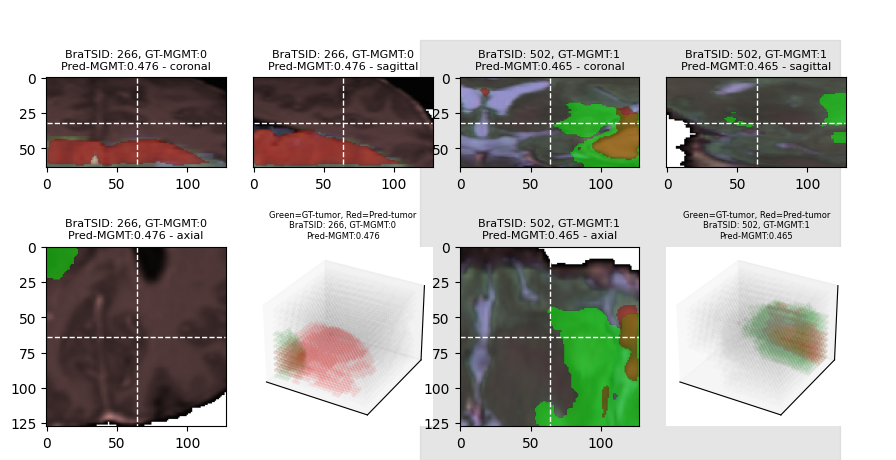


Summary val Epoch  1:  Loss:0.4662 	 DSC:53.3758
 Acc:0.4746 MSE:0.7001	tumor : 0.5338

Epoch: 1.17 Loss:0.5716 	 DSC:42.8402
 Acc:0.6300 MSE:0.7046	tumor:0.4284

Epoch: 1.34 Loss:0.5750 	 DSC:42.4984
 Acc:0.5650 MSE:0.7011	tumor:0.4250

Epoch: 1.52 Loss:0.5701 	 DSC:42.9924
 Acc:0.5667 MSE:0.6995	tumor:0.4299

Epoch: 1.69 Loss:0.5663 	 DSC:43.3728
 Acc:0.5200 MSE:0.6990	tumor:0.4337

Epoch: 1.86 Loss:0.5658 	 DSC:43.4152
 Acc:0.5240 MSE:0.6997	tumor:0.4342

Summary train Epoch  2:  Loss:0.5573 	 DSC:44.2682
 Acc:0.5156 MSE:0.6992	tumor : 0.4427


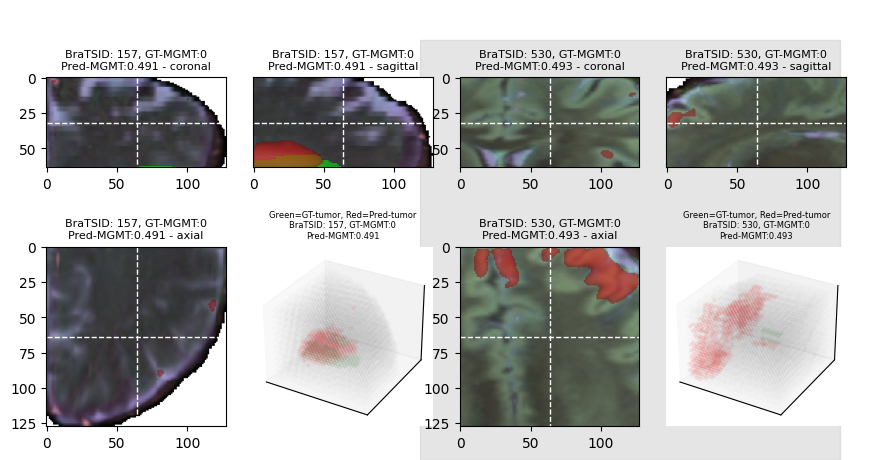


Summary val Epoch  2:  Loss:0.4759 	 DSC:52.4063
 Acc:0.4661 MSE:0.6949	tumor : 0.5241

Epoch: 2.17 Loss:0.5380 	 DSC:46.2029
 Acc:0.7200 MSE:0.6960	tumor:0.4620

Epoch: 2.34 Loss:0.5416 	 DSC:45.8415
 Acc:0.6300 MSE:0.6964	tumor:0.4584

Epoch: 2.52 Loss:0.5487 	 DSC:45.1319
 Acc:0.5433 MSE:0.6956	tumor:0.4513

Epoch: 2.69 Loss:0.5453 	 DSC:45.4684
 Acc:0.5925 MSE:0.6952	tumor:0.4547

Epoch: 2.86 Loss:0.5432 	 DSC:45.6775
 Acc:0.5480 MSE:0.6951	tumor:0.4568

Summary train Epoch  3:  Loss:0.5403 	 DSC:45.9684
 Acc:0.5311 MSE:0.6948	tumor : 0.4597


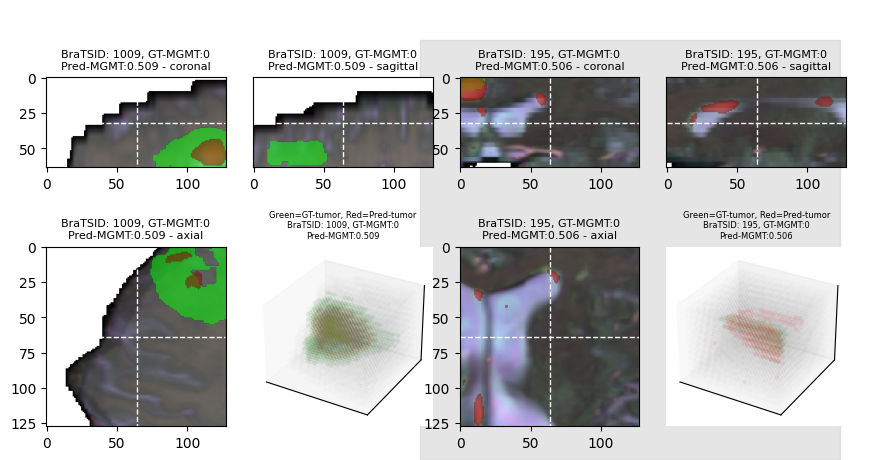


Summary val Epoch  3:  Loss:0.4672 	 DSC:53.2755
 Acc:0.5678 MSE:0.6926	tumor : 0.5328

Epoch: 3.17 Loss:0.5340 	 DSC:46.6000
 Acc:0.4900 MSE:0.6984	tumor:0.4660

Epoch: 3.34 Loss:0.5566 	 DSC:44.3415
 Acc:0.4450 MSE:0.6969	tumor:0.4434

Epoch: 3.52 Loss:0.5363 	 DSC:46.3692
 Acc:0.4500 MSE:0.6977	tumor:0.4637

Epoch: 3.69 Loss:0.5166 	 DSC:48.3368
 Acc:0.4650 MSE:0.6969	tumor:0.4834

Epoch: 3.86 Loss:0.5160 	 DSC:48.4034
 Acc:0.4960 MSE:0.6963	tumor:0.4840

Summary train Epoch  4:  Loss:0.5181 	 DSC:48.1890
 Acc:0.5156 MSE:0.6962	tumor : 0.4819


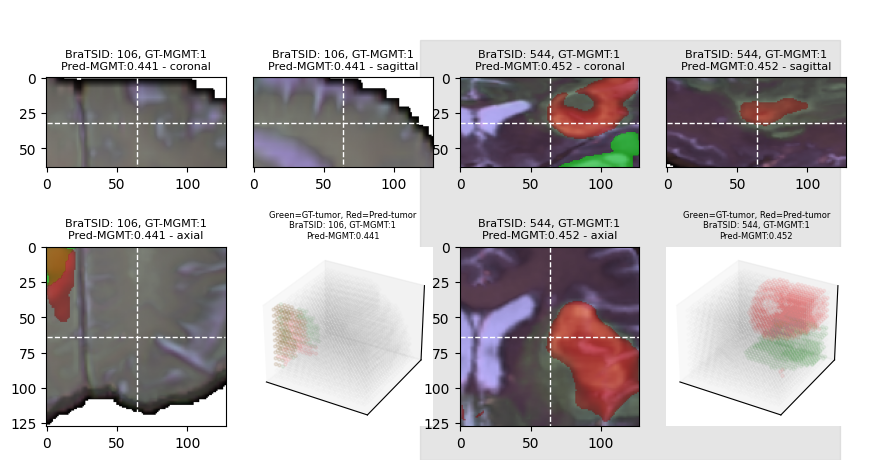


Summary val Epoch  4:  Loss:0.4676 	 DSC:53.2360
 Acc:0.4661 MSE:0.7085	tumor : 0.5324

Epoch: 4.17 Loss:0.5047 	 DSC:49.5264
 Acc:0.6700 MSE:0.6983	tumor:0.4953

Epoch: 4.34 Loss:0.4907 	 DSC:50.9286
 Acc:0.6800 MSE:0.6965	tumor:0.5093

Epoch: 4.52 Loss:0.4839 	 DSC:51.6095
 Acc:0.5867 MSE:0.6954	tumor:0.5161

Epoch: 4.69 Loss:0.4828 	 DSC:51.7220
 Acc:0.5850 MSE:0.6954	tumor:0.5172

Epoch: 4.86 Loss:0.4807 	 DSC:51.9287
 Acc:0.5600 MSE:0.6951	tumor:0.5193

Summary train Epoch  5:  Loss:0.5014 	 DSC:49.8570
 Acc:0.5519 MSE:0.6950	tumor : 0.4986


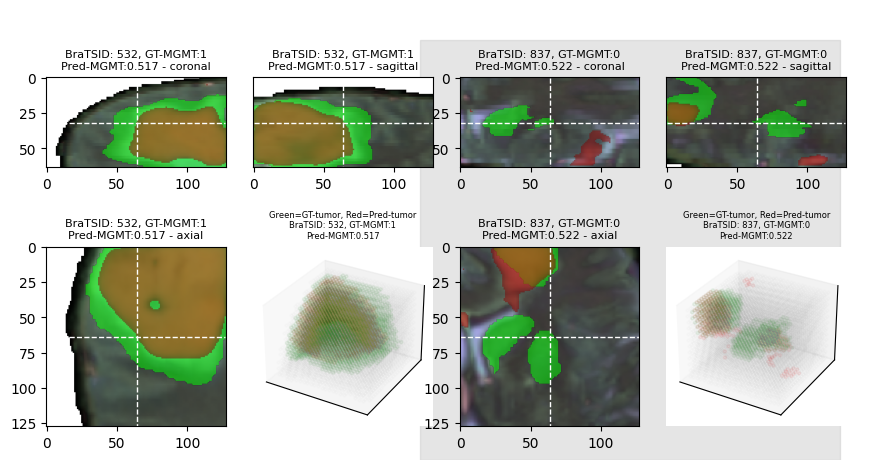


Summary val Epoch  5:  Loss:0.5132 	 DSC:48.6826
 Acc:0.5254 MSE:0.6937	tumor : 0.4868

Epoch: 5.17 Loss:0.5647 	 DSC:43.5259
 Acc:0.6900 MSE:0.6955	tumor:0.4353

Epoch: 5.34 Loss:0.5235 	 DSC:47.6488
 Acc:0.5300 MSE:0.6956	tumor:0.4765

Epoch: 5.52 Loss:0.5123 	 DSC:48.7667
 Acc:0.5700 MSE:0.6959	tumor:0.4877

Epoch: 5.69 Loss:0.4879 	 DSC:51.2068
 Acc:0.5625 MSE:0.6960	tumor:0.5121

Epoch: 5.86 Loss:0.4756 	 DSC:52.4406
 Acc:0.5900 MSE:0.6959	tumor:0.5244

Summary train Epoch  6:  Loss:0.4682 	 DSC:53.1774
 Acc:0.5606 MSE:0.6959	tumor : 0.5318


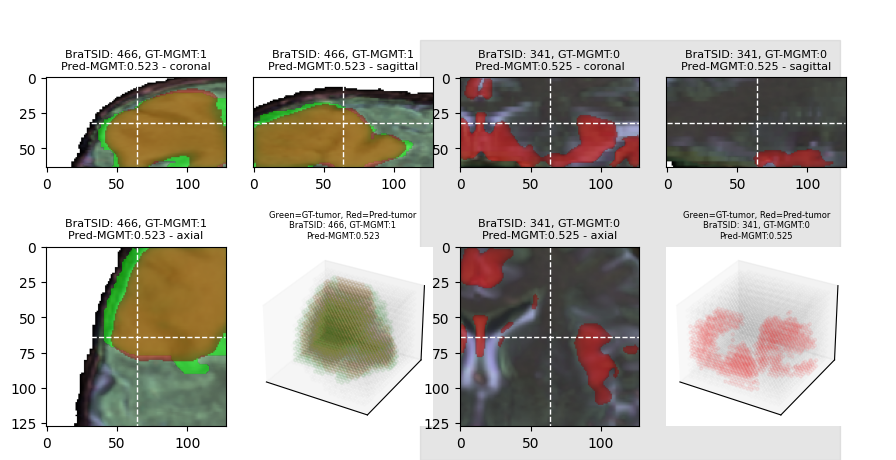


Summary val Epoch  6:  Loss:0.4651 	 DSC:53.4879
 Acc:0.5254 MSE:0.6913	tumor : 0.5349

Epoch: 6.17 Loss:0.4926 	 DSC:50.7437
 Acc:0.5100 MSE:0.6957	tumor:0.5074

Epoch: 6.34 Loss:0.4679 	 DSC:53.2150
 Acc:0.6700 MSE:0.6955	tumor:0.5321

Epoch: 6.52 Loss:0.4855 	 DSC:51.4463
 Acc:0.6033 MSE:0.6955	tumor:0.5145

Epoch: 6.69 Loss:0.4737 	 DSC:52.6276
 Acc:0.6250 MSE:0.6955	tumor:0.5263

Epoch: 6.86 Loss:0.4668 	 DSC:53.3166
 Acc:0.6140 MSE:0.6951	tumor:0.5332

Summary train Epoch  7:  Loss:0.4749 	 DSC:52.5070
 Acc:0.6003 MSE:0.6952	tumor : 0.5251


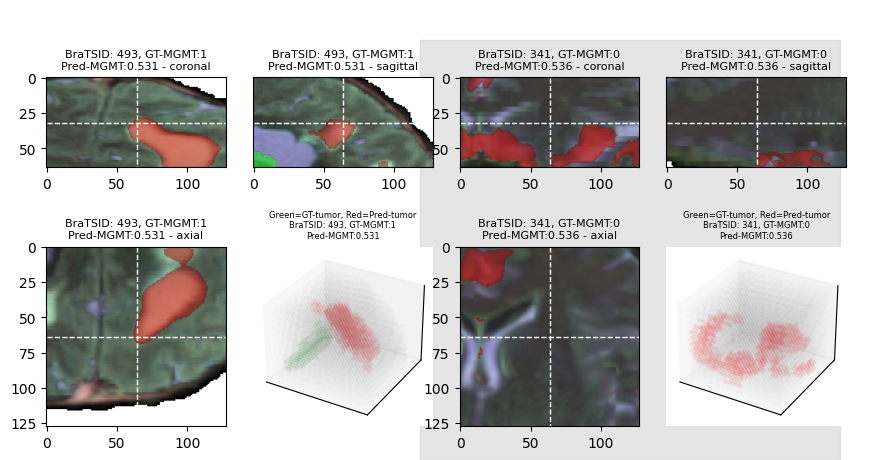


Summary val Epoch  7:  Loss:0.4530 	 DSC:54.6950
 Acc:0.5339 MSE:0.6907	tumor : 0.5470

Epoch: 7.17 Loss:0.4632 	 DSC:53.6798
 Acc:0.5900 MSE:0.6948	tumor:0.5368

Epoch: 7.34 Loss:0.4175 	 DSC:58.2546
 Acc:0.5550 MSE:0.6944	tumor:0.5825

Epoch: 7.52 Loss:0.4548 	 DSC:54.5236
 Acc:0.5433 MSE:0.6941	tumor:0.5452

Epoch: 7.69 Loss:0.4451 	 DSC:55.4895
 Acc:0.5375 MSE:0.6950	tumor:0.5549

Epoch: 7.86 Loss:0.4479 	 DSC:55.2095
 Acc:0.6000 MSE:0.6948	tumor:0.5521

Summary train Epoch  8:  Loss:0.4662 	 DSC:53.3840
 Acc:0.5519 MSE:0.6949	tumor : 0.5338


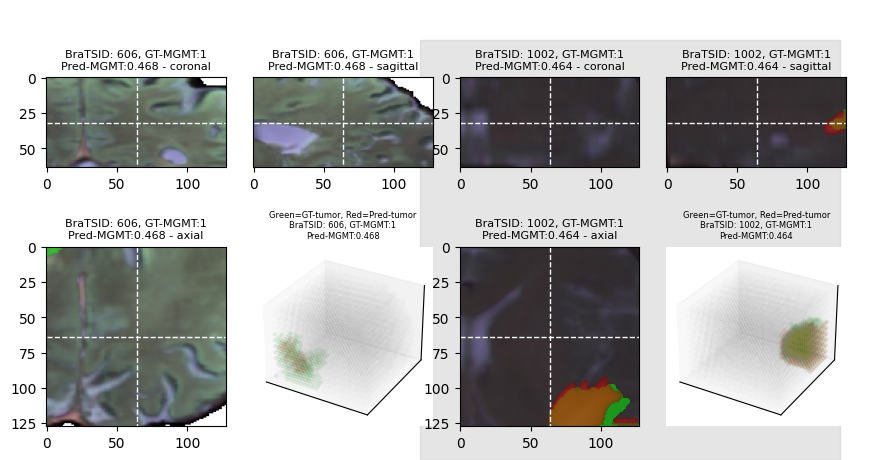


Summary val Epoch  8:  Loss:0.4087 	 DSC:59.1349
 Acc:0.4746 MSE:0.6978	tumor : 0.5913

Epoch: 8.17 Loss:0.4476 	 DSC:55.2376
 Acc:0.5600 MSE:0.6959	tumor:0.5524

Epoch: 8.34 Loss:0.4640 	 DSC:53.6022
 Acc:0.4550 MSE:0.6955	tumor:0.5360

Epoch: 8.52 Loss:0.4931 	 DSC:50.6917
 Acc:0.4333 MSE:0.6958	tumor:0.5069

Epoch: 8.69 Loss:0.4783 	 DSC:52.1674
 Acc:0.4975 MSE:0.6955	tumor:0.5217

Epoch: 8.86 Loss:0.4696 	 DSC:53.0410
 Acc:0.5160 MSE:0.6954	tumor:0.5304

Summary train Epoch  9:  Loss:0.4679 	 DSC:53.2110
 Acc:0.5398 MSE:0.6953	tumor : 0.5321


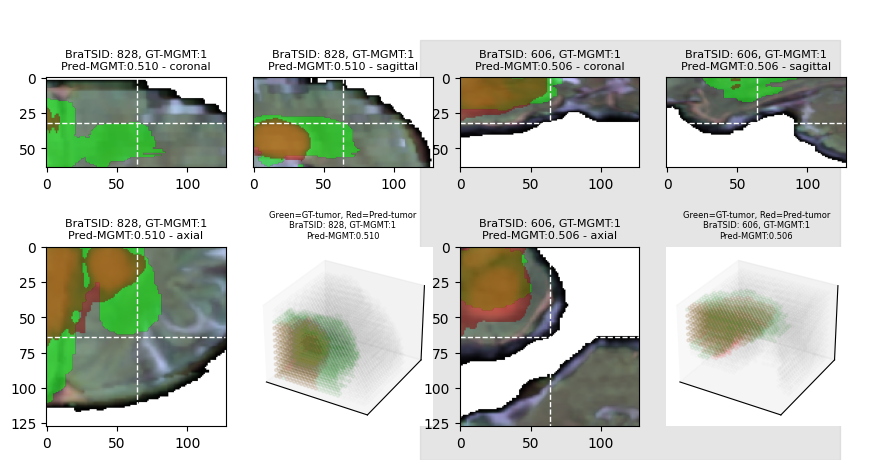


Summary val Epoch  9:  Loss:0.3901 	 DSC:60.9947
 Acc:0.5339 MSE:0.6926	tumor : 0.6099

Epoch: 9.17 Loss:0.4891 	 DSC:51.0929
 Acc:0.3600 MSE:0.6944	tumor:0.5109

Epoch: 9.34 Loss:0.4752 	 DSC:52.4841
 Acc:0.3900 MSE:0.6939	tumor:0.5248

Epoch: 9.52 Loss:0.4796 	 DSC:52.0428
 Acc:0.4700 MSE:0.6945	tumor:0.5204

Epoch: 9.69 Loss:0.4602 	 DSC:53.9784
 Acc:0.5275 MSE:0.6948	tumor:0.5398

Epoch: 9.86 Loss:0.4692 	 DSC:53.0791
 Acc:0.5160 MSE:0.6948	tumor:0.5308

Summary train Epoch 10:  Loss:0.4575 	 DSC:54.2483
 Acc:0.5433 MSE:0.6948	tumor : 0.5425


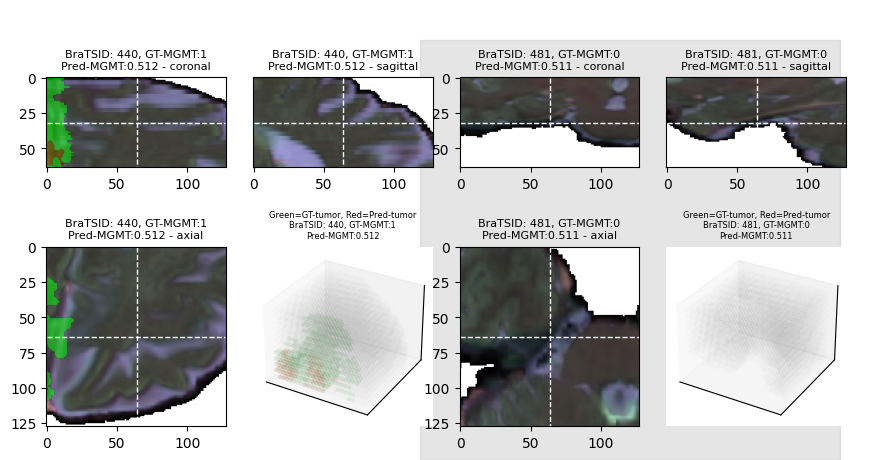


Summary val Epoch 10:  Loss:0.4299 	 DSC:57.0058
 Acc:0.5254 MSE:0.6921	tumor : 0.5701

Epoch: 10.17 Loss:0.4274 	 DSC:57.2604
 Acc:0.5300 MSE:0.6956	tumor:0.5726

Epoch: 10.34 Loss:0.4454 	 DSC:55.4604
 Acc:0.6400 MSE:0.6962	tumor:0.5546

Epoch: 10.52 Loss:0.4565 	 DSC:54.3457
 Acc:0.5267 MSE:0.6954	tumor:0.5435

Epoch: 10.69 Loss:0.4521 	 DSC:54.7900
 Acc:0.5550 MSE:0.6955	tumor:0.5479

Epoch: 10.86 Loss:0.4428 	 DSC:55.7239
 Acc:0.5340 MSE:0.6955	tumor:0.5572

Summary train Epoch 11:  Loss:0.4445 	 DSC:55.5519
 Acc:0.5242 MSE:0.6956	tumor : 0.5555


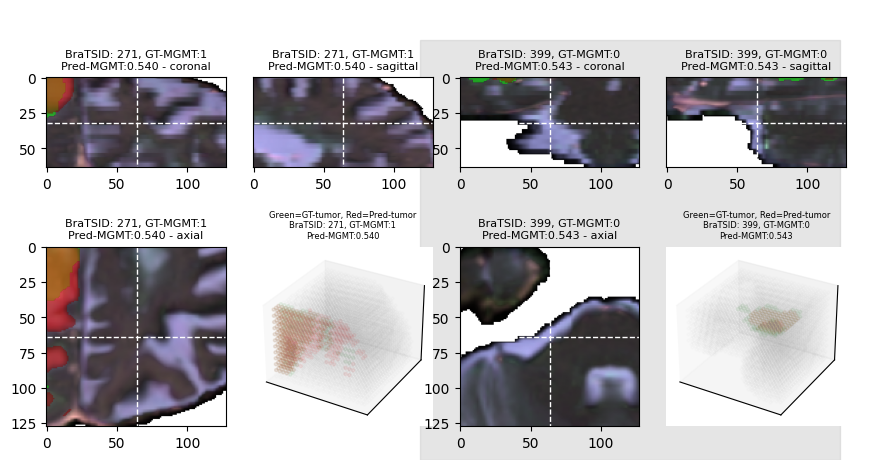


Summary val Epoch 11:  Loss:0.3862 	 DSC:61.3843
 Acc:0.5254 MSE:0.6932	tumor : 0.6138

Epoch: 11.17 Loss:0.4699 	 DSC:53.0091
 Acc:0.4200 MSE:0.6954	tumor:0.5301

Epoch: 11.34 Loss:0.4772 	 DSC:52.2751
 Acc:0.6250 MSE:0.6948	tumor:0.5228

Epoch: 11.52 Loss:0.4638 	 DSC:53.6225
 Acc:0.6000 MSE:0.6943	tumor:0.5362

Epoch: 11.69 Loss:0.4438 	 DSC:55.6203
 Acc:0.5250 MSE:0.6945	tumor:0.5562

Epoch: 11.86 Loss:0.4444 	 DSC:55.5609
 Acc:0.5400 MSE:0.6945	tumor:0.5556

Summary train Epoch 12:  Loss:0.4371 	 DSC:56.2919
 Acc:0.5952 MSE:0.6941	tumor : 0.5629


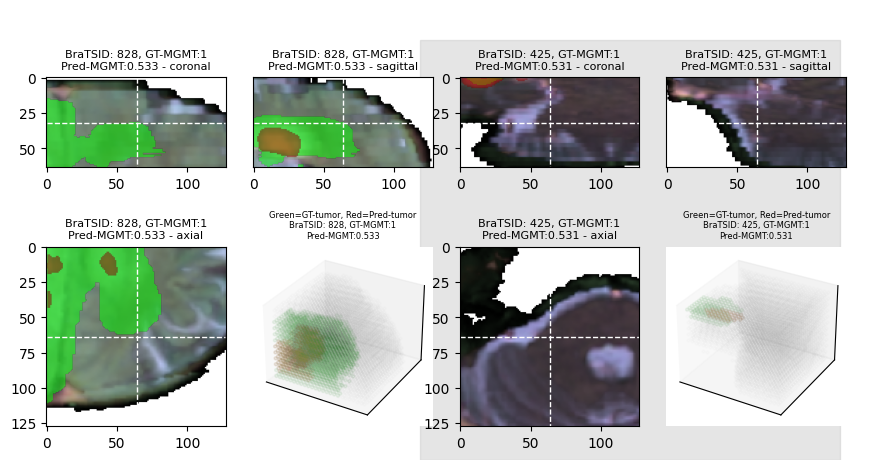


Summary val Epoch 12:  Loss:0.4261 	 DSC:57.3867
 Acc:0.5339 MSE:0.6908	tumor : 0.5739

Epoch: 12.17 Loss:0.4650 	 DSC:53.4959
 Acc:0.6400 MSE:0.6930	tumor:0.5350

Epoch: 12.34 Loss:0.4433 	 DSC:55.6676
 Acc:0.6450 MSE:0.6940	tumor:0.5567

Epoch: 12.52 Loss:0.4252 	 DSC:57.4828
 Acc:0.6800 MSE:0.6942	tumor:0.5748

Epoch: 12.69 Loss:0.4308 	 DSC:56.9189
 Acc:0.6100 MSE:0.6946	tumor:0.5692

Epoch: 12.86 Loss:0.4250 	 DSC:57.4975
 Acc:0.5780 MSE:0.6946	tumor:0.5750

Summary train Epoch 13:  Loss:0.4277 	 DSC:57.2334
 Acc:0.5917 MSE:0.6946	tumor : 0.5723


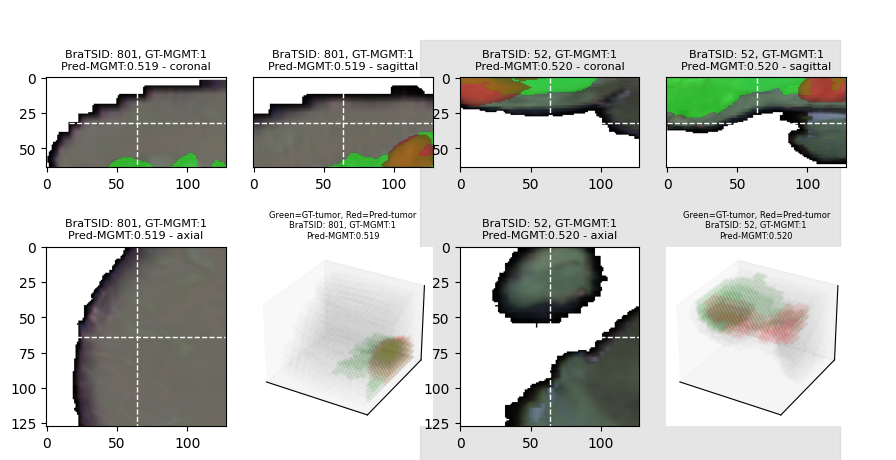


Summary val Epoch 13:  Loss:0.3216 	 DSC:67.8370
 Acc:0.5254 MSE:0.6917	tumor : 0.6784

Epoch: 13.17 Loss:0.4074 	 DSC:59.2602
 Acc:0.6200 MSE:0.6928	tumor:0.5926

Epoch: 13.34 Loss:0.3733 	 DSC:62.6667
 Acc:0.5950 MSE:0.6939	tumor:0.6267

Epoch: 13.52 Loss:0.3851 	 DSC:61.4948
 Acc:0.5467 MSE:0.6938	tumor:0.6149

Epoch: 13.69 Loss:0.3823 	 DSC:61.7675
 Acc:0.5075 MSE:0.6937	tumor:0.6177

Epoch: 13.86 Loss:0.3800 	 DSC:61.9971
 Acc:0.5400 MSE:0.6940	tumor:0.6200

Summary train Epoch 14:  Loss:0.3915 	 DSC:60.8486
 Acc:0.5744 MSE:0.6939	tumor : 0.6085


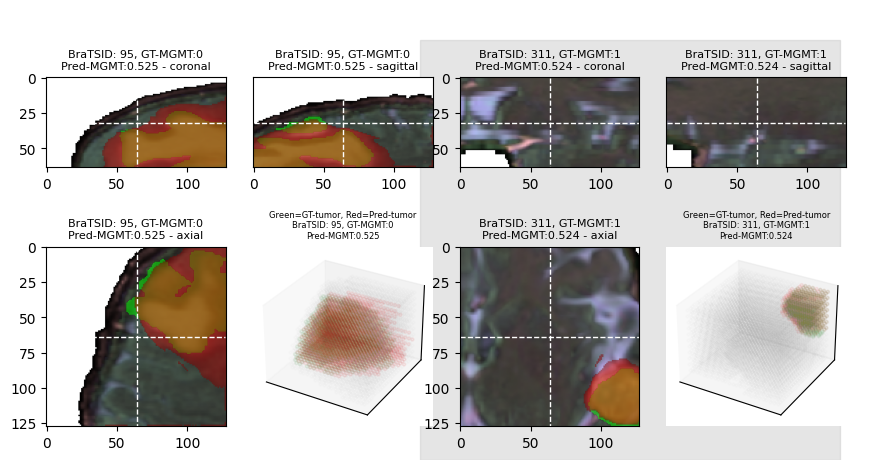


Summary val Epoch 14:  Loss:0.3554 	 DSC:64.4599
 Acc:0.5339 MSE:0.6912	tumor : 0.6446

Epoch: 14.17 Loss:0.3815 	 DSC:61.8529
 Acc:0.5900 MSE:0.6947	tumor:0.6185

Epoch: 14.34 Loss:0.3823 	 DSC:61.7663
 Acc:0.6400 MSE:0.6951	tumor:0.6177

Epoch: 14.52 Loss:0.4044 	 DSC:59.5647
 Acc:0.7067 MSE:0.6947	tumor:0.5956

Epoch: 14.69 Loss:0.4063 	 DSC:59.3684
 Acc:0.6725 MSE:0.6945	tumor:0.5937

Epoch: 14.86 Loss:0.4000 	 DSC:60.0048
 Acc:0.6140 MSE:0.6944	tumor:0.6000

Summary train Epoch 15:  Loss:0.4063 	 DSC:59.3723
 Acc:0.6194 MSE:0.6943	tumor : 0.5937


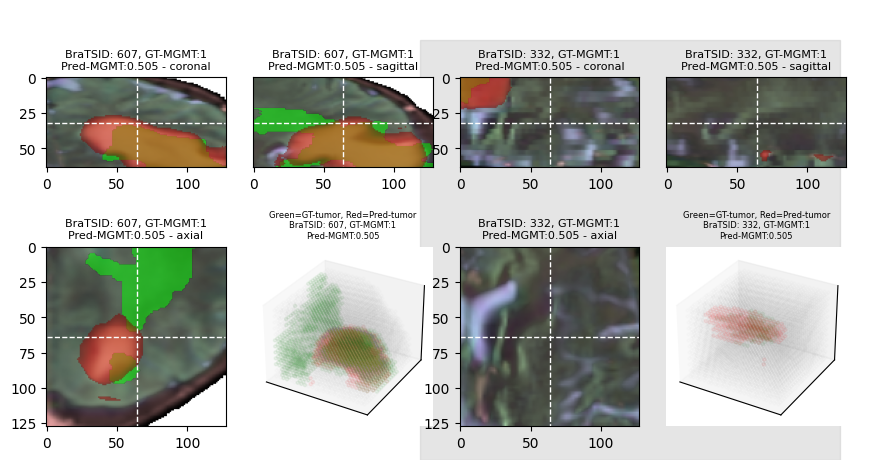


Summary val Epoch 15:  Loss:0.4029 	 DSC:59.7109
 Acc:0.5085 MSE:0.6935	tumor : 0.5971

Epoch: 15.17 Loss:0.4340 	 DSC:56.5972
 Acc:0.6200 MSE:0.6950	tumor:0.5660

Epoch: 15.34 Loss:0.4205 	 DSC:57.9510
 Acc:0.6750 MSE:0.6944	tumor:0.5795

Epoch: 15.52 Loss:0.4156 	 DSC:58.4424
 Acc:0.6267 MSE:0.6939	tumor:0.5844

Epoch: 15.69 Loss:0.4001 	 DSC:59.9883
 Acc:0.5425 MSE:0.6938	tumor:0.5999

Epoch: 15.86 Loss:0.4007 	 DSC:59.9335
 Acc:0.6140 MSE:0.6938	tumor:0.5993

Summary train Epoch 16:  Loss:0.3993 	 DSC:60.0699
 Acc:0.6142 MSE:0.6939	tumor : 0.6007


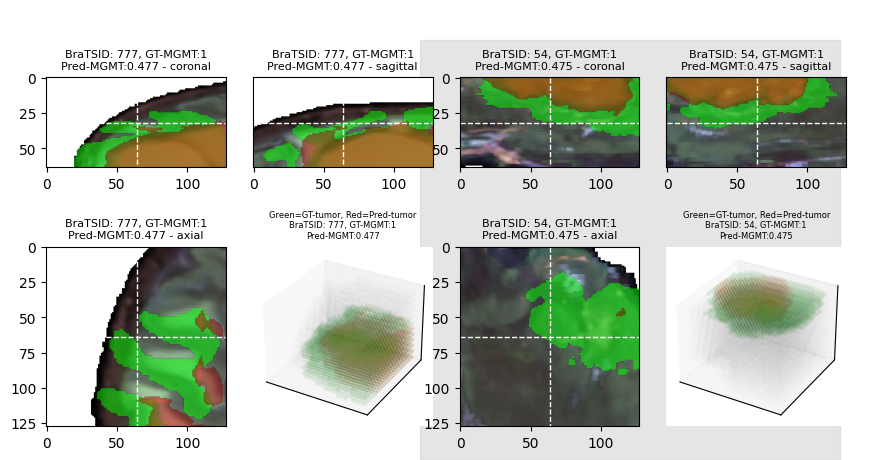


Summary val Epoch 16:  Loss:0.3753 	 DSC:62.4688
 Acc:0.4746 MSE:0.6968	tumor : 0.6247

Epoch: 16.17 Loss:0.4620 	 DSC:53.8032
 Acc:0.3500 MSE:0.6952	tumor:0.5380

Epoch: 16.34 Loss:0.4062 	 DSC:59.3796
 Acc:0.4800 MSE:0.6941	tumor:0.5938

Epoch: 16.52 Loss:0.4165 	 DSC:58.3510
 Acc:0.4833 MSE:0.6941	tumor:0.5835

Epoch: 16.69 Loss:0.4176 	 DSC:58.2397
 Acc:0.5425 MSE:0.6940	tumor:0.5824

Epoch: 16.86 Loss:0.4167 	 DSC:58.3258
 Acc:0.5640 MSE:0.6939	tumor:0.5833

Summary train Epoch 17:  Loss:0.4062 	 DSC:59.3840
 Acc:0.6194 MSE:0.6940	tumor : 0.5938


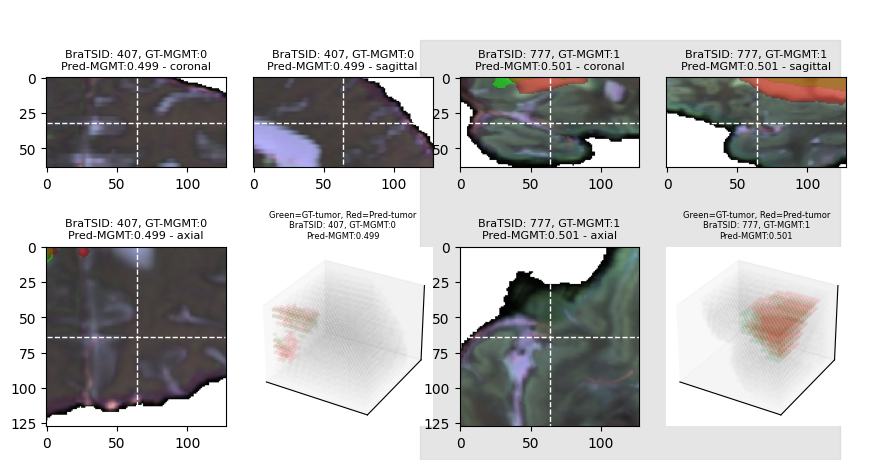


Summary val Epoch 17:  Loss:0.3448 	 DSC:65.5181
 Acc:0.5847 MSE:0.6928	tumor : 0.6552

Epoch: 17.17 Loss:0.3514 	 DSC:64.8616
 Acc:0.4200 MSE:0.6942	tumor:0.6486

Epoch: 17.34 Loss:0.3718 	 DSC:62.8249
 Acc:0.5900 MSE:0.6933	tumor:0.6282

Epoch: 17.52 Loss:0.4041 	 DSC:59.5901
 Acc:0.6333 MSE:0.6935	tumor:0.5959

Epoch: 17.69 Loss:0.3821 	 DSC:61.7862
 Acc:0.6200 MSE:0.6935	tumor:0.6179

Epoch: 17.86 Loss:0.3968 	 DSC:60.3208
 Acc:0.6160 MSE:0.6936	tumor:0.6032

Summary train Epoch 18:  Loss:0.3946 	 DSC:60.5385
 Acc:0.5900 MSE:0.6935	tumor : 0.6054


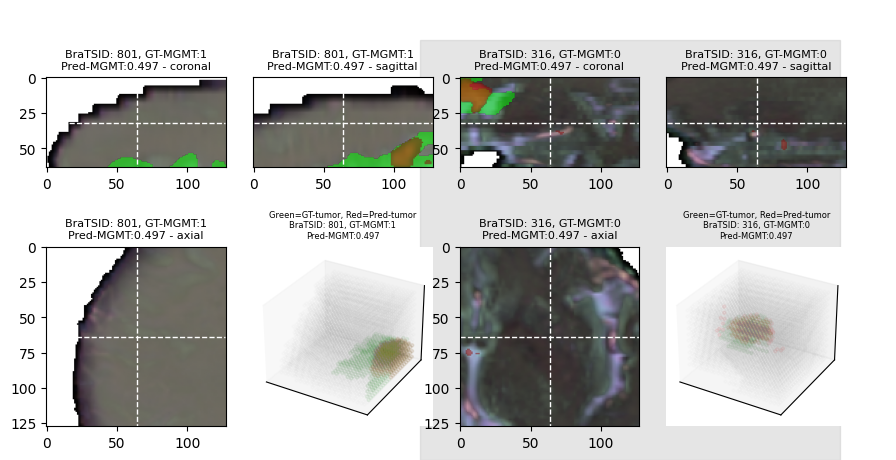


Summary val Epoch 18:  Loss:0.3915 	 DSC:60.8506
 Acc:0.4915 MSE:0.6930	tumor : 0.6085

Epoch: 18.17 Loss:0.3735 	 DSC:62.6533
 Acc:0.3400 MSE:0.6934	tumor:0.6265

Epoch: 18.34 Loss:0.3629 	 DSC:63.7121
 Acc:0.4750 MSE:0.6935	tumor:0.6371

Epoch: 18.52 Loss:0.3844 	 DSC:61.5602
 Acc:0.5133 MSE:0.6933	tumor:0.6156

Epoch: 18.69 Loss:0.3820 	 DSC:61.7986
 Acc:0.5225 MSE:0.6933	tumor:0.6180

Epoch: 18.86 Loss:0.3859 	 DSC:61.4115
 Acc:0.5640 MSE:0.6934	tumor:0.6141

Summary train Epoch 19:  Loss:0.3814 	 DSC:61.8619
 Acc:0.5761 MSE:0.6935	tumor : 0.6186


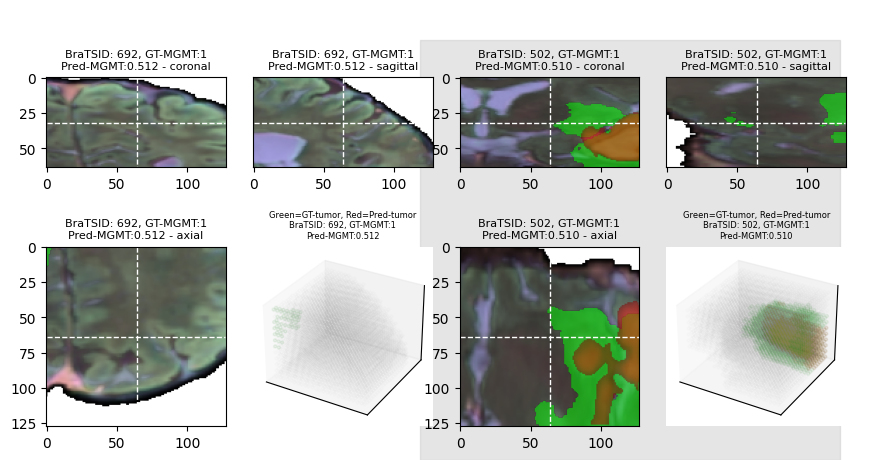


Summary val Epoch 19:  Loss:0.3537 	 DSC:64.6328
 Acc:0.5254 MSE:0.6920	tumor : 0.6463

Epoch: 19.17 Loss:0.4297 	 DSC:57.0306
 Acc:0.7100 MSE:0.6927	tumor:0.5703

Epoch: 19.34 Loss:0.3919 	 DSC:60.8071
 Acc:0.7050 MSE:0.6930	tumor:0.6081

Epoch: 19.52 Loss:0.3966 	 DSC:60.3430
 Acc:0.6433 MSE:0.6930	tumor:0.6034

Epoch: 19.69 Loss:0.3963 	 DSC:60.3737
 Acc:0.5750 MSE:0.6932	tumor:0.6037

Epoch: 19.86 Loss:0.4047 	 DSC:59.5269
 Acc:0.6000 MSE:0.6933	tumor:0.5953

Summary train Epoch 20:  Loss:0.4043 	 DSC:59.5721
 Acc:0.6211 MSE:0.6932	tumor : 0.5957


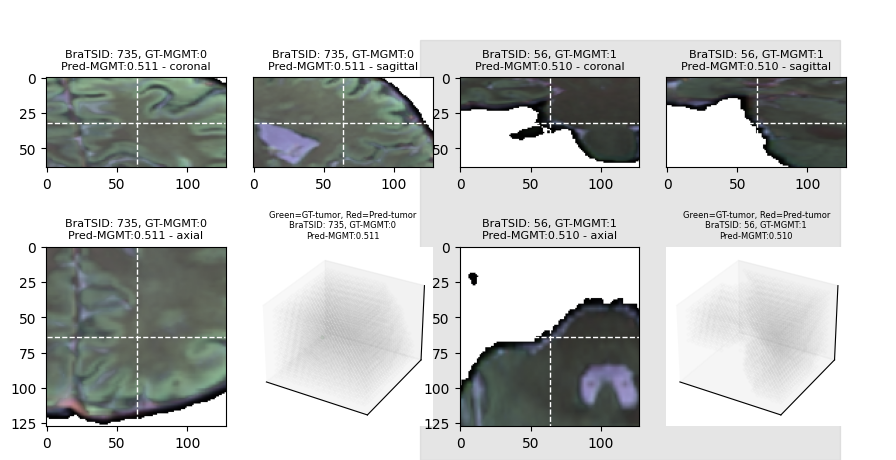


Summary val Epoch 20:  Loss:0.4007 	 DSC:59.9344
 Acc:0.5254 MSE:0.6926	tumor : 0.5993

Epoch: 20.17 Loss:0.3514 	 DSC:64.8650
 Acc:0.8300 MSE:0.6935	tumor:0.6486

Epoch: 20.34 Loss:0.3443 	 DSC:65.5747
 Acc:0.7350 MSE:0.6931	tumor:0.6557

Epoch: 20.52 Loss:0.3612 	 DSC:63.8774
 Acc:0.7267 MSE:0.6929	tumor:0.6388

Epoch: 20.69 Loss:0.3634 	 DSC:63.6563
 Acc:0.7600 MSE:0.6931	tumor:0.6366

Epoch: 20.86 Loss:0.3622 	 DSC:63.7803
 Acc:0.7740 MSE:0.6932	tumor:0.6378

Summary train Epoch 21:  Loss:0.3624 	 DSC:63.7592
 Acc:0.7595 MSE:0.6932	tumor : 0.6376


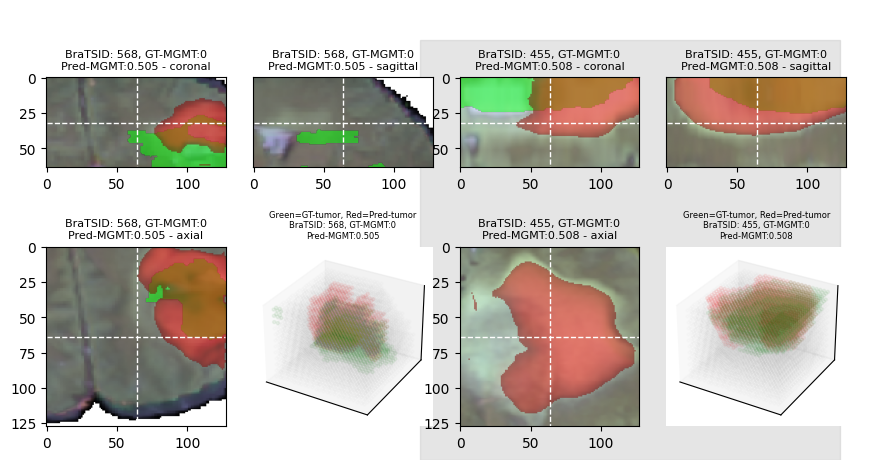


Summary val Epoch 21:  Loss:0.3782 	 DSC:62.1761
 Acc:0.5593 MSE:0.6927	tumor : 0.6218

Epoch: 21.17 Loss:0.4281 	 DSC:57.1916
 Acc:0.7500 MSE:0.6935	tumor:0.5719

Epoch: 21.34 Loss:0.3845 	 DSC:61.5483
 Acc:0.7100 MSE:0.6939	tumor:0.6155

Epoch: 21.52 Loss:0.3671 	 DSC:63.2921
 Acc:0.6967 MSE:0.6933	tumor:0.6329

Epoch: 21.69 Loss:0.3686 	 DSC:63.1362
 Acc:0.7050 MSE:0.6934	tumor:0.6314

Epoch: 21.86 Loss:0.3810 	 DSC:61.9049
 Acc:0.6980 MSE:0.6935	tumor:0.6190

Summary train Epoch 22:  Loss:0.3797 	 DSC:62.0269
 Acc:0.7024 MSE:0.6936	tumor : 0.6203


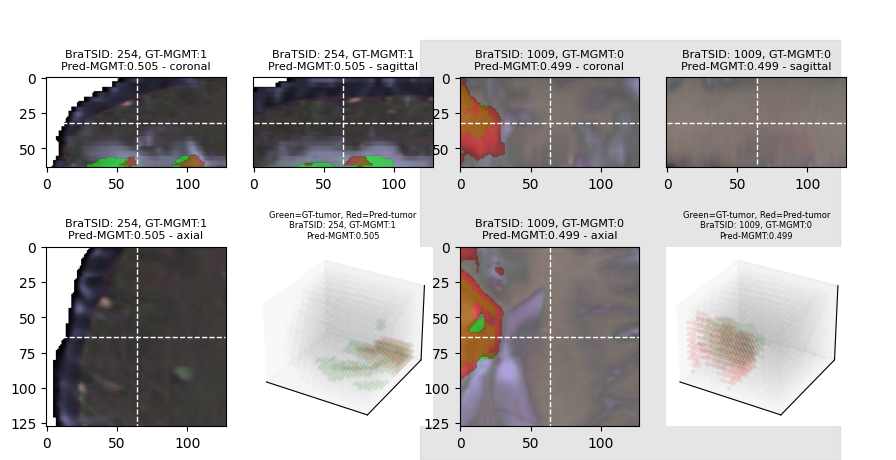


Summary val Epoch 22:  Loss:0.3343 	 DSC:66.5729
 Acc:0.5424 MSE:0.6926	tumor : 0.6657

Epoch: 22.17 Loss:0.3405 	 DSC:65.9538
 Acc:0.7100 MSE:0.6931	tumor:0.6595

Epoch: 22.34 Loss:0.3374 	 DSC:66.2645
 Acc:0.6800 MSE:0.6934	tumor:0.6626

Epoch: 22.52 Loss:0.3395 	 DSC:66.0538
 Acc:0.6767 MSE:0.6937	tumor:0.6605

Epoch: 22.69 Loss:0.3587 	 DSC:64.1258
 Acc:0.6625 MSE:0.6936	tumor:0.6413

Epoch: 22.86 Loss:0.3656 	 DSC:63.4383
 Acc:0.6720 MSE:0.6937	tumor:0.6344

Summary train Epoch 23:  Loss:0.3615 	 DSC:63.8504
 Acc:0.6886 MSE:0.6936	tumor : 0.6385


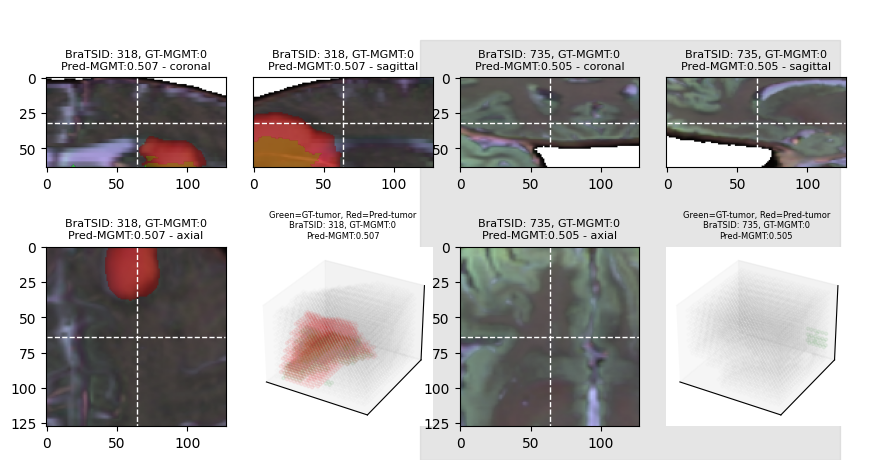


Summary val Epoch 23:  Loss:0.3651 	 DSC:63.4890
 Acc:0.5169 MSE:0.6930	tumor : 0.6349

Epoch: 23.17 Loss:0.3380 	 DSC:66.2019
 Acc:0.6000 MSE:0.6932	tumor:0.6620

Epoch: 23.34 Loss:0.3546 	 DSC:64.5382
 Acc:0.6150 MSE:0.6935	tumor:0.6454

Epoch: 23.52 Loss:0.3698 	 DSC:63.0241
 Acc:0.6267 MSE:0.6934	tumor:0.6302

Epoch: 23.69 Loss:0.3614 	 DSC:63.8625
 Acc:0.6350 MSE:0.6932	tumor:0.6386

Epoch: 23.86 Loss:0.3524 	 DSC:64.7610
 Acc:0.6400 MSE:0.6934	tumor:0.6476

Summary train Epoch 24:  Loss:0.3518 	 DSC:64.8153
 Acc:0.6505 MSE:0.6934	tumor : 0.6482


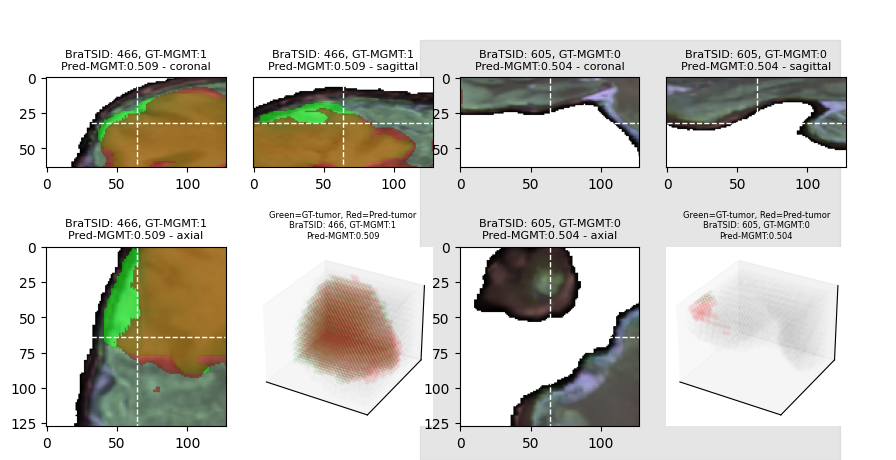


Summary val Epoch 24:  Loss:0.3502 	 DSC:64.9793
 Acc:0.5339 MSE:0.6923	tumor : 0.6498

Epoch: 24.17 Loss:0.4149 	 DSC:58.5083
 Acc:0.7100 MSE:0.6947	tumor:0.5851

Epoch: 24.34 Loss:0.3796 	 DSC:62.0436
 Acc:0.6900 MSE:0.6943	tumor:0.6204

Epoch: 24.52 Loss:0.3846 	 DSC:61.5398
 Acc:0.7000 MSE:0.6942	tumor:0.6154

Epoch: 24.69 Loss:0.3847 	 DSC:61.5309
 Acc:0.7100 MSE:0.6940	tumor:0.6153

Epoch: 24.86 Loss:0.3814 	 DSC:61.8633
 Acc:0.6960 MSE:0.6938	tumor:0.6186

Summary train Epoch 25:  Loss:0.3816 	 DSC:61.8368
 Acc:0.6696 MSE:0.6939	tumor : 0.6184


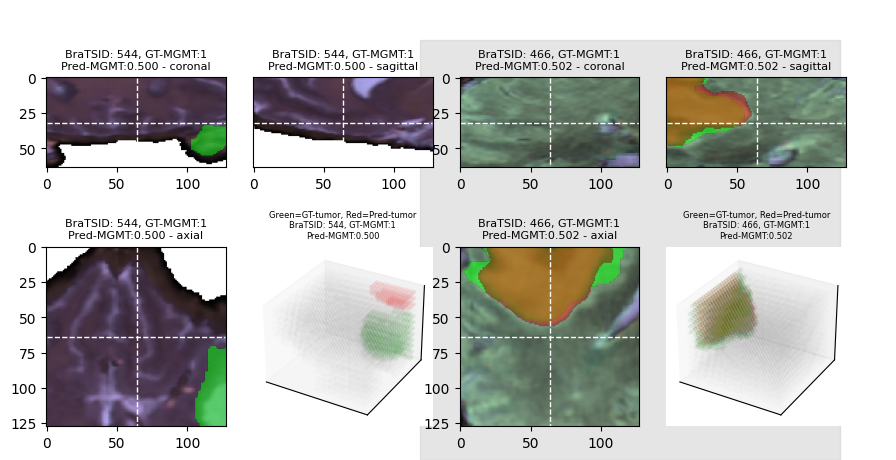


Summary val Epoch 25:  Loss:0.3849 	 DSC:61.5103
 Acc:0.5508 MSE:0.6929	tumor : 0.6151

Epoch: 25.17 Loss:0.3460 	 DSC:65.4017
 Acc:0.6500 MSE:0.6927	tumor:0.6540

Epoch: 25.34 Loss:0.3650 	 DSC:63.5018
 Acc:0.6750 MSE:0.6929	tumor:0.6350

Epoch: 25.52 Loss:0.3760 	 DSC:62.3950
 Acc:0.6733 MSE:0.6932	tumor:0.6240

Epoch: 25.69 Loss:0.3627 	 DSC:63.7328
 Acc:0.6750 MSE:0.6933	tumor:0.6373

Epoch: 25.86 Loss:0.3772 	 DSC:62.2848
 Acc:0.5840 MSE:0.6935	tumor:0.6228

Summary train Epoch 26:  Loss:0.3777 	 DSC:62.2330
 Acc:0.5692 MSE:0.6936	tumor : 0.6223


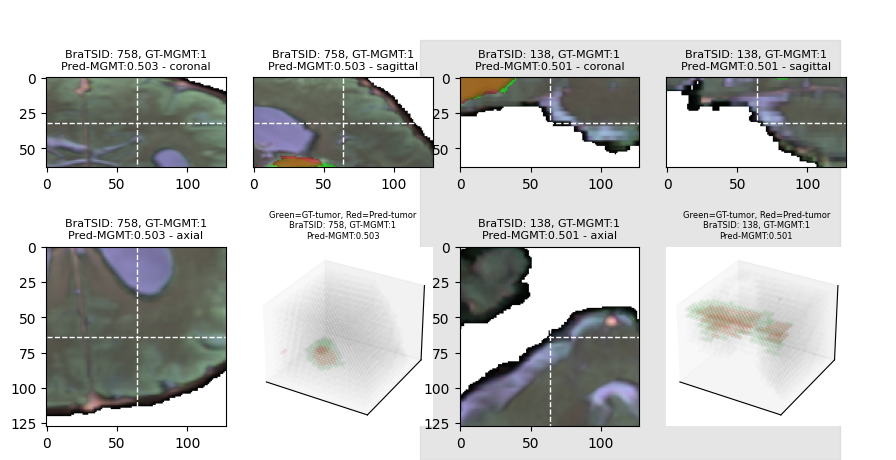


Summary val Epoch 26:  Loss:0.3629 	 DSC:63.7099
 Acc:0.5339 MSE:0.6929	tumor : 0.6371

Epoch: 26.17 Loss:0.4660 	 DSC:53.3951
 Acc:0.6100 MSE:0.6930	tumor:0.5340

Epoch: 26.34 Loss:0.3979 	 DSC:60.2052
 Acc:0.7450 MSE:0.6930	tumor:0.6021

Epoch: 26.52 Loss:0.4105 	 DSC:58.9462
 Acc:0.6633 MSE:0.6933	tumor:0.5895

Epoch: 26.69 Loss:0.4069 	 DSC:59.3135
 Acc:0.7250 MSE:0.6932	tumor:0.5931

Epoch: 26.86 Loss:0.3958 	 DSC:60.4248
 Acc:0.6560 MSE:0.6932	tumor:0.6042

Summary train Epoch 27:  Loss:0.3963 	 DSC:60.3728
 Acc:0.6626 MSE:0.6933	tumor : 0.6037


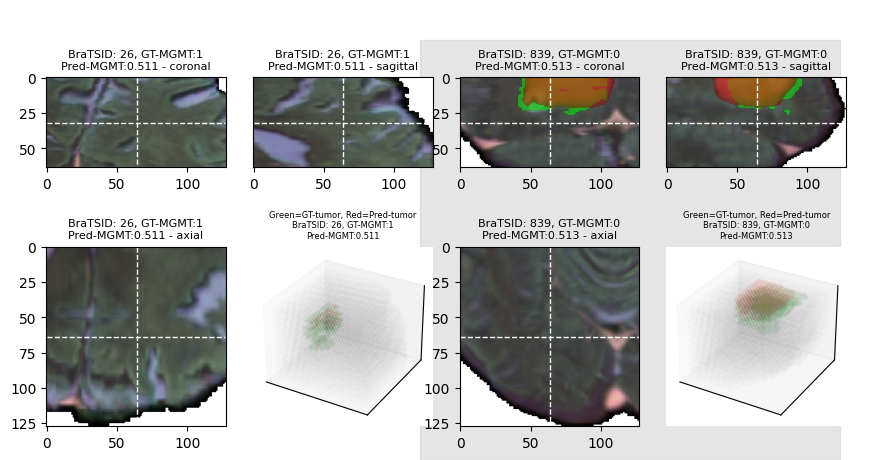


Summary val Epoch 27:  Loss:0.3459 	 DSC:65.4092
 Acc:0.5339 MSE:0.6924	tumor : 0.6541

Epoch: 27.17 Loss:0.4592 	 DSC:54.0753
 Acc:0.9400 MSE:0.6937	tumor:0.5408

Epoch: 27.34 Loss:0.4377 	 DSC:56.2348
 Acc:0.8700 MSE:0.6937	tumor:0.5623

Epoch: 27.52 Loss:0.4131 	 DSC:58.6891
 Acc:0.6833 MSE:0.6941	tumor:0.5869

Epoch: 27.69 Loss:0.3765 	 DSC:62.3501
 Acc:0.6800 MSE:0.6941	tumor:0.6235

Epoch: 27.86 Loss:0.3726 	 DSC:62.7413
 Acc:0.6580 MSE:0.6939	tumor:0.6274

Summary train Epoch 28:  Loss:0.3712 	 DSC:62.8800
 Acc:0.6488 MSE:0.6939	tumor : 0.6288


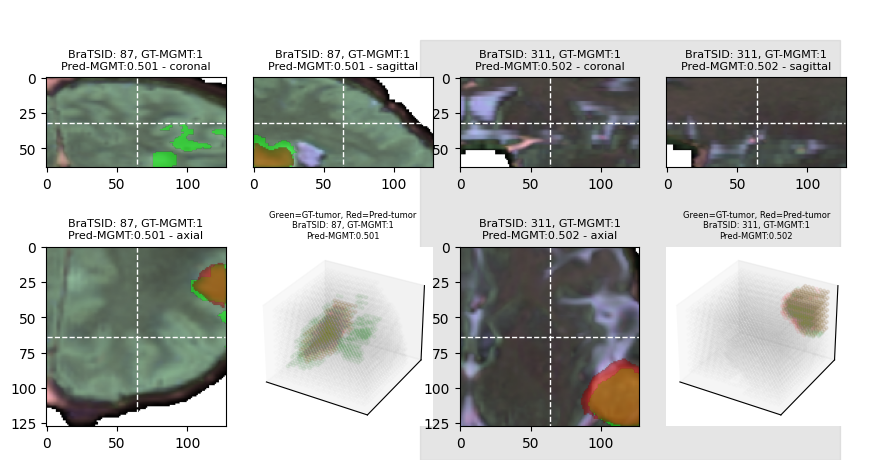


Summary val Epoch 28:  Loss:0.3794 	 DSC:62.0609
 Acc:0.5254 MSE:0.6931	tumor : 0.6206

Epoch: 28.17 Loss:0.4151 	 DSC:58.4898
 Acc:0.1900 MSE:0.6931	tumor:0.5849

Epoch: 28.34 Loss:0.3900 	 DSC:61.0040
 Acc:0.4100 MSE:0.6934	tumor:0.6100

Epoch: 28.52 Loss:0.3904 	 DSC:60.9614
 Acc:0.4800 MSE:0.6936	tumor:0.6096

Epoch: 28.69 Loss:0.3961 	 DSC:60.3867
 Acc:0.5325 MSE:0.6938	tumor:0.6039

Epoch: 28.86 Loss:0.3913 	 DSC:60.8699
 Acc:0.5880 MSE:0.6937	tumor:0.6087

Summary train Epoch 29:  Loss:0.3897 	 DSC:61.0313
 Acc:0.5727 MSE:0.6939	tumor : 0.6103


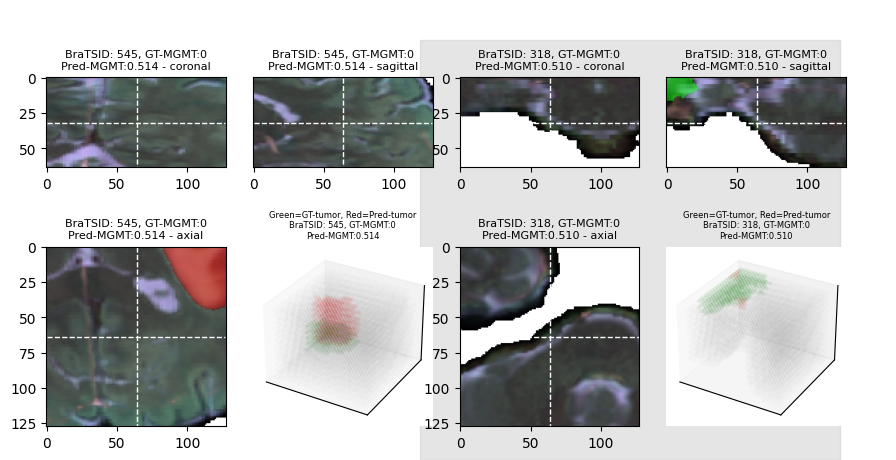


Summary val Epoch 29:  Loss:0.3955 	 DSC:60.4515
 Acc:0.5339 MSE:0.6914	tumor : 0.6045


In [37]:
train_args = {
    'nEpochs' : 30, # 100
    'classes' : 1,
    'class_names' : ['tumor'],
    'inChannels' : 3,
    'log_dir' : '../runs/',
    'save': f'../output/one_chan_3D-Unet_fold-{fold}',
    'model':'3DUnet1chan',
    'dataset_name':'registeredv3'
}
trainer = BraTS2021_Trainer(train_args, model, loss, optimizer, train_data_loader=train_generator,
                            valid_data_loader=val_generator, lr_scheduler=scheduler)
trainer.training()

### Validation inference and TTA

In [38]:
# reload model
model = UNet3D_v2(out_channels=1).cuda()
model.load_state_dict(torch.load(f'../output/one_chan_3D-Unet_fold-{fold}/one_chan_3D-Unet_fold-{fold}_last_epoch.pth')['model_state_dict'])
_ = model.eval()

In [39]:
# load validation set
val_ds = BraTS2021(
    mode='val', 
    npy_fns_list=sample_fns_val, 
    label_list=lbls_val,
    augmentations=None,
    volume_normalize=True,
    max_out_size=(320,320,160)
)

In [40]:
def inference_sample_tta(model, image, batch_size=1):
    """Inference 3d image with tta and average predictions. Image shape: 3xWxHxD"""
    model.eval()
    
    def _flip(im, index=0):
        if index == 0:
            return im
        elif index == 1:
            return torch.flip(im, [1])
        elif index == 2:
            return torch.flip(im, [2])
        elif index == 3:
            return torch.flip(im, [3])
        elif index == 4:
            return torch.flip(im, [1,2])
        elif index == 5:
            return torch.flip(im, [1,3])
        elif index == 6:
            return torch.flip(im, [1,2,3])
        elif index == 7:
            return torch.flip(im, [2,3])
        
    def _predict(batch):
        batch.requires_grad=False
        seg_batch_flipped, clf_batch = model(batch.cuda())
        seg_batch_flipped, clf_batch = seg_batch_flipped.detach().cpu(), clf_batch.detach().cpu()
        # logits to preds
        clf_batch = torch.sigmoid(clf_batch)
        return seg_batch_flipped, clf_batch
    
    batch = torch.stack([_flip(image.clone(), index) for index in range(8)], dim=0)
    seg_batch_flipped_list, clf_batch_list = [],[]
    
    with torch.no_grad():    
        for start in range(0, 8, batch_size):
            seg_batch_flipped, clf_batch = _predict(batch[start:start + batch_size])
            
            seg_batch_flipped_list = seg_batch_flipped_list + [seg for seg in seg_batch_flipped]
            clf_batch_list = clf_batch_list + [clf for clf in clf_batch]
    
    # flip masks back
    seg_batch = torch.stack([_flip(seg, index) for index, seg in enumerate(seg_batch_flipped_list)], dim=0)
    
    # average results
    seg = torch.mean(seg_batch, dim=0)
    clf = torch.mean(torch.stack(clf_batch_list, dim=0), dim=0)
    return seg, clf

In [41]:
from sklearn.metrics import roc_curve, auc

def eval_val_fold(out_dir):
    # create dirs
    if not os.path.exists(out_dir): os.mkdir(out_dir)
    pred_dir = os.path.join(out_dir, 'oof_preds')
    if not os.path.exists(pred_dir): os.mkdir(pred_dir)
    vis_dir = os.path.join(out_dir, 'vis')
    if not os.path.exists(vis_dir): os.mkdir(vis_dir)
    
    preds = []
    gts = []
    
    for val_index in tqdm(range(len(val_ds))):
        sample = val_ds.__getitem__(val_index)
        bratsid = f'{int(sample["BraTSID"]):05d}'
        
        gts.append(float(sample['label']))
        
        seg, clf = inference_sample_tta(model, sample['image'])
        preds.append(float(clf.cpu().numpy()))
        
        # save oof preds
        seg_fn = os.path.join(pred_dir, f'{bratsid}_seg.npy')
        np.save(seg_fn, seg.cpu().numpy())
        pred_fn = os.path.join(pred_dir, f'{bratsid}_pred.npy')
        np.save(pred_fn, clf.cpu().numpy())
        
        vis_fn = os.path.join(vis_dir, f'{bratsid}.png')
        show_mri_sample(
            sample, 
            pred_mask=seg.unsqueeze(0), 
            pred_lbl=[clf.numpy()],
            save_fn=vis_fn
        )
        plt.close('all')
    
    auc_fn = os.path.join(out_dir, 'auc.png')
    fpr, tpr, _ = roc_curve(np.array(gts), np.array(preds))
    roc_auc = auc(fpr, tpr)
    
    acc = np.sum((np.array(gts) > 0.5) == (np.array(preds) > 0.5)) / len(gts)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label=f'ROC curve (area = {roc_auc:.2f}), Acc. = {acc*100:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig(auc_fn, transparent=False)

In [42]:
out_dir = os.path.join(f'../output/one_chan_3D-Unet_fold-{fold}', 'eval')
eval_val_fold(out_dir)

  0%|          | 0/113 [00:00<?, ?it/s]